# Data Prepration

In [ ]:
pip install yfinance

### Test the base accuracy of Nvidia's upstream and downstream companies, selecting stocks from Nasdaq that have data for the past 10 years.

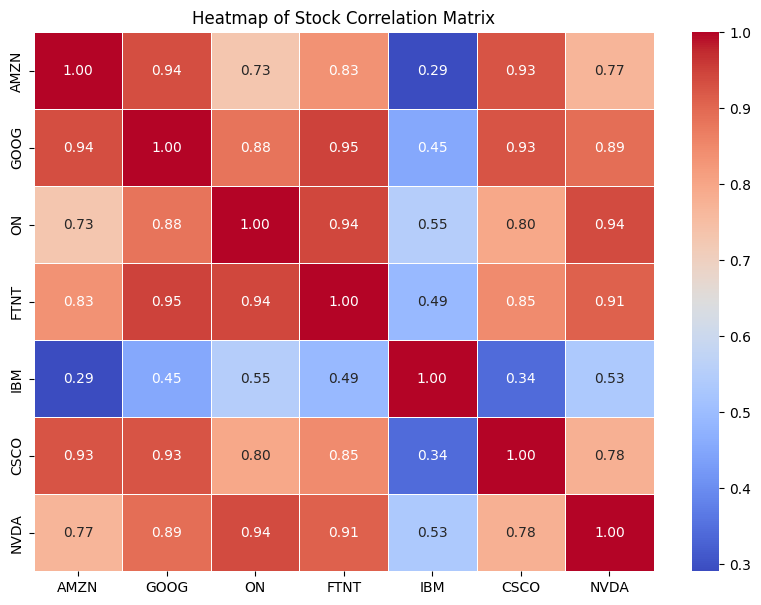

          AMZN      GOOG        ON      FTNT       IBM      CSCO      NVDA
AMZN  1.000000  0.935881  0.731098  0.834470  0.290496  0.927385  0.767958
GOOG  0.935881  1.000000  0.881692  0.949573  0.453949  0.925961  0.891246
ON    0.731098  0.881692  1.000000  0.942551  0.548426  0.795276  0.936872
FTNT  0.834470  0.949573  0.942551  1.000000  0.492132  0.847029  0.909671
IBM   0.290496  0.453949  0.548426  0.492132  1.000000  0.341097  0.532249
CSCO  0.927385  0.925961  0.795276  0.847029  0.341097  1.000000  0.780802
NVDA  0.767958  0.891246  0.936872  0.909671  0.532249  0.780802  1.000000
                             AMZN       GOOG    ON   FTNT        IBM  \
Date                                                                   
2010-01-04 00:00:00-05:00  6.6950  15.610239  8.87  1.800  76.767426   
2010-01-05 00:00:00-05:00  6.7345  15.541497  8.79  1.839  75.840065   
2010-01-06 00:00:00-05:00  6.6125  15.149715  8.90  1.941  75.347389   
2010-01-07 00:00:00-05:00  6.5000  14.79

In [ ]:
#Upstream and downstream company of Nvidia
#https://www.partnerbase.com/nvidia
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#Amazon, Google, ON Semiconductor, Fortinet, IBM, Cicso, NVIDIA
symbols = ['AMZN', 'GOOG', 'ON', 'FTNT', 'IBM', 'CSCO','NVDA']

start_date = '2010-01-01'
end_date = '2024-01-01'

def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data

stock_data = {}
for symbol in symbols:
    stock_data[symbol] = fetch_stock_data(symbol, start_date, end_date)

combined_data = pd.concat([stock_data[symbol]['Close'] for symbol in symbols], axis=1)
combined_data.columns = symbols

# Calculate the correlation matrix
correlation_matrix = combined_data.corr()

# Plotting the heatmap of the correlation matrix
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap of Stock Correlation Matrix')
plt.show()

# Print the correlation matrix
print(correlation_matrix)
print(combined_data.head())
portfolio1 = combined_data.drop('NVDA',axis=1)
print(portfolio1.head())
target = combined_data['NVDA']
print(target.head())

# Base LSTM after tuning

Epoch 1/100
71/71 [==============================] - 3s 13ms/step - loss: 0.0090 - val_loss: 0.0054
Epoch 2/100
71/71 [==============================] - 0s 7ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 3/100
71/71 [==============================] - 0s 7ms/step - loss: 0.0031 - val_loss: 0.0050
Epoch 4/100
71/71 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 0.0052
Epoch 5/100
71/71 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 6/100
71/71 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 7/100
71/71 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 8/100
71/71 [==============================] - 0s 7ms/step - loss: 0.0020 - val_loss: 0.0035
Epoch 9/100
71/71 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 10/100
71/71 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 11

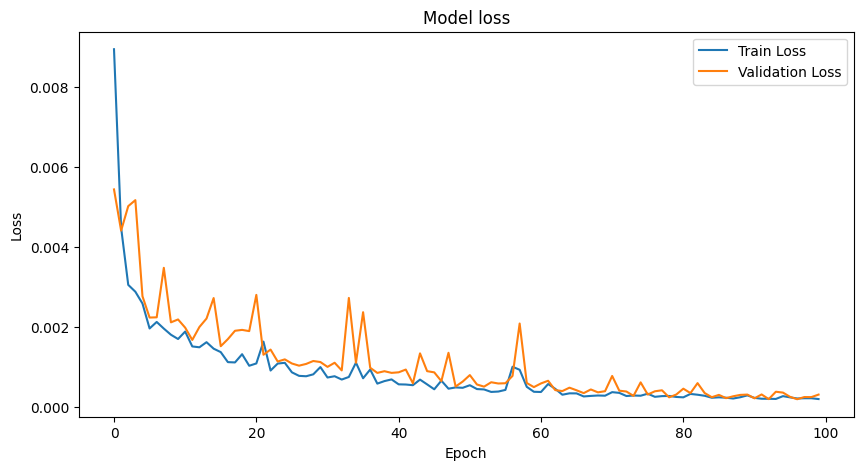

In [ ]:
#check for the best number of epochs
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

scaler_x = MinMaxScaler(feature_range=(0, 1))
portfolio1_scaled = scaler_x.fit_transform(portfolio1)

scaler_y = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps), :]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X, y = create_dataset(portfolio1_scaled, target_scaled, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Setup Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model with a reasonable number of epochs
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


From these, the validation loss is at its lowest at Epoch 97. After this point, although the training loss continues to decrease slightly, the validation loss increases, suggesting the beginning of overfitting beyond this point.

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Function to create a 3D array suitable for LSTM input
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps), :]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Scale the data
scaler_x = MinMaxScaler(feature_range=(0, 1))
portfolio1_scaled = scaler_x.fit_transform(portfolio1)

scaler_y = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

time_steps = 10
X, y = create_dataset(portfolio1_scaled, target_scaled, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

# Model definition
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout for regularization
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Setup callbacks for early stopping and learning rate scheduling
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    LearningRateScheduler(scheduler, verbose=1)
]

# Train the model
history = model.fit(X_train, y_train, epochs=97, batch_size=32, validation_split=0.2, verbose=1, callbacks=callbacks_list)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions)  # Invert scaling for predictions
actuals = scaler_y.inverse_transform(y_test)  # Invert scaling for actual values

# Display some predictions
print("Predicted vs Actual:")
print(np.hstack((predictions[:5], actuals[:5])))



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/97
71/71 [==============================] - 6s 27ms/step - loss: 0.0090 - val_loss: 0.0060 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/97
71/71 [==============================] - 1s 12ms/step - loss: 0.0046 - val_loss: 0.0038 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/97
71/71 [==============================] - 1s 12ms/step - loss: 0.0036 - val_loss: 0.0079 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/97
71/71 [==============================] - 1s 12ms/step - loss: 0.0038 - val_loss: 0.0039 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/97
71/71 [==============================] - 1s 12ms/step - loss: 0.0029 - val_loss: 0.0027 - lr: 0.0010

Epoch 6: LearningRateScheduler setting 

110/110 [==============================] - 1s 5ms/step


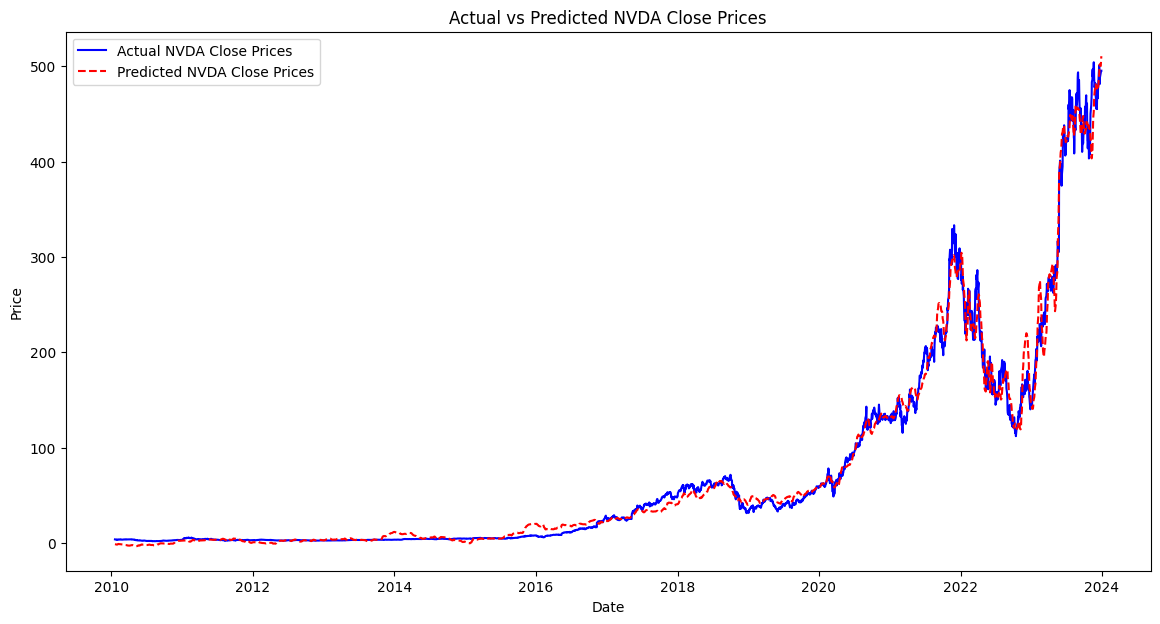

In [ ]:
import matplotlib.pyplot as plt

# Generate predictions for the entire dataset
X_full, y_full = create_dataset(portfolio1_scaled, target_scaled, time_steps)
predictions_full = model.predict(X_full)
predictions_full_inverted = scaler_y.inverse_transform(predictions_full)

# The actual values need to be aligned with the predictions, starting from the end of the first time_step period
actual_values_aligned = target.values[time_steps:]
dates_aligned = target.index[time_steps:]

# Ensure the lengths match after trimming (in case of any indexing issues)
min_length = min(len(predictions_full_inverted), len(actual_values_aligned))
predictions_full_inverted = predictions_full_inverted[:min_length]
actual_values_aligned = actual_values_aligned[:min_length]
dates_aligned = dates_aligned[:min_length]

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(dates_aligned, actual_values_aligned, label='Actual NVDA Close Prices', color='blue')
plt.plot(dates_aligned, predictions_full_inverted, label='Predicted NVDA Close Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted NVDA Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print("RMSE: ", rmse)
print(f'Coefficient of Determination (R² score): {r2}')

Mean Absolute Error (MAE): 6.623969343394189
Mean Squared Error (MSE): 122.63183216898985
RMSE:  11.07392577946005
Coefficient of Determination (R² score): 0.9872434151450183




---



---



---



# lstm base from the original source

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import numpy as np

# Scale the data
scaler_x = MinMaxScaler(feature_range=(0, 1))
portfolio1_scaled = scaler_x.fit_transform(portfolio1)

scaler_y = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

# Function to create a 3D array suitable for LSTM input
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps), :]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X, y = create_dataset(portfolio1_scaled, target_scaled, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#model defined
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')


history = model.fit(X_train, y_train, epochs=97, batch_size=32, validation_split=0.2, verbose=1)

predictions = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions)  # Invert scaling for predictions
actuals = scaler_y.inverse_transform(y_test)  # Invert scaling for actual values

# Display some predictions
print("Predicted vs Actual:")
print(np.hstack((predictions[:5], actuals[:5])))

Epoch 1/5
71/71 [==============================] - 3s 16ms/step - loss: 0.0082 - val_loss: 0.0058
Epoch 2/5
71/71 [==============================] - 1s 8ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 3/5
71/71 [==============================] - 1s 8ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 4/5
71/71 [==============================] - 1s 8ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 5/5
22/22 [==============================] - 1s 3ms/step
Predicted vs Actual:
[[  2.33453703   3.25642323]
 [ 18.76115608  10.33399105]
 [ 56.66641617  44.58513641]
 [ 18.62350845   7.59728289]
 [150.44552612 136.81022644]]


110/110 [==============================] - 0s 3ms/step


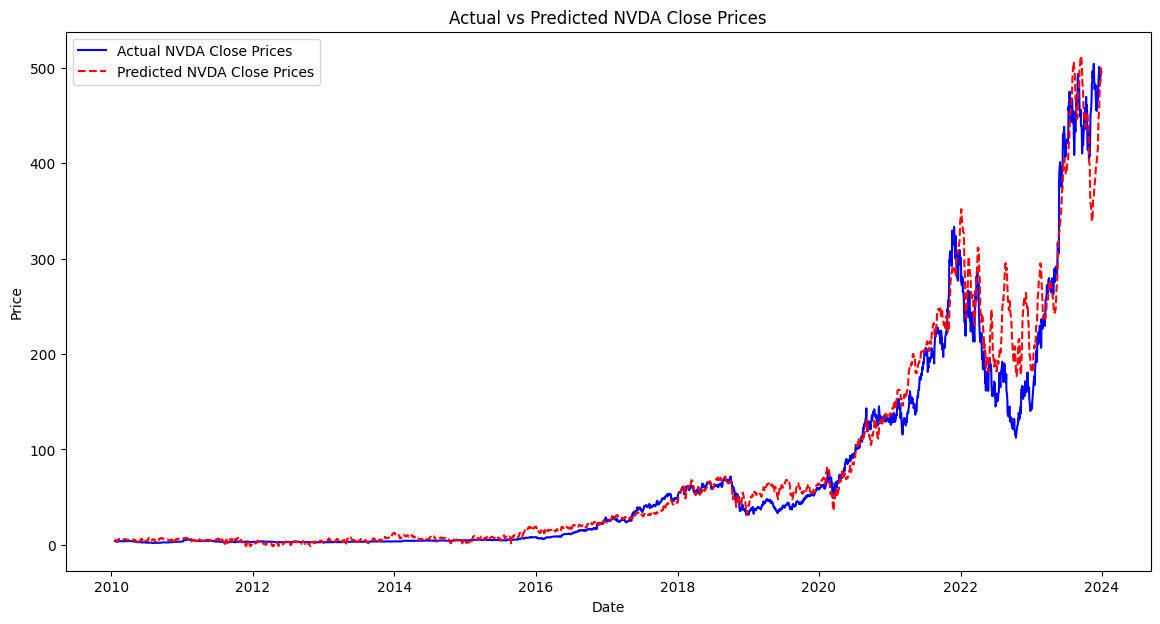

In [ ]:
import matplotlib.pyplot as plt

# Assuming `portfolio1_scaled` and `target_scaled` cover the entire period you're interested in

# Generate predictions for the entire dataset
X_full, y_full = create_dataset(portfolio1_scaled, target_scaled, time_steps)
predictions_full = model.predict(X_full)
predictions_full_inverted = scaler_y.inverse_transform(predictions_full)

# The actual values need to be aligned with the predictions, starting from the end of the first time_step period
actual_values_aligned = target.values[time_steps:]
dates_aligned = target.index[time_steps:]

# Ensure the lengths match after trimming (in case of any indexing issues)
min_length = min(len(predictions_full_inverted), len(actual_values_aligned))
predictions_full_inverted = predictions_full_inverted[:min_length]
actual_values_aligned = actual_values_aligned[:min_length]
dates_aligned = dates_aligned[:min_length]

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(dates_aligned, actual_values_aligned, label='Actual NVDA Close Prices', color='blue')
plt.plot(dates_aligned, predictions_full_inverted, label='Predicted NVDA Close Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted NVDA Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print("RMSE: ", rmse)
print(f'Coefficient of Determination (R² score): {r2}')

Mean Absolute Error (MAE): 10.623075591360521
Mean Squared Error (MSE): 414.7355244768029
RMSE:  20.365056456509098
Coefficient of Determination (R² score): 0.9568577846649713


# FASTRNN_CNN_BiLSTM (Inspired by : https://ietresearch.onlinelibrary.wiley.com/doi/full/10.1049/cit2.12052）

In [ ]:
#preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

scaler_x = MinMaxScaler(feature_range=(0, 1))
portfolio1_scaled = scaler_x.fit_transform(portfolio1)

scaler_y = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

time_steps = 30  # Using a broader time window
X, y = create_dataset(portfolio1_scaled, target_scaled, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Epoch 1/100
70/70 [==============================] - 7s 32ms/step - loss: 0.0098 - val_loss: 0.0056
Epoch 2/100
 9/70 [==>...........................] - ETA: 0s - loss: 0.0074

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


70/70 [==============================] - 1s 16ms/step - loss: 0.0055 - val_loss: 0.0069
Epoch 3/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0049 - val_loss: 0.0037
Epoch 4/100
70/70 [==============================] - 1s 15ms/step - loss: 0.0049 - val_loss: 0.0038
Epoch 5/100
70/70 [==============================] - 1s 17ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 6/100
70/70 [==============================] - 1s 15ms/step - loss: 0.0039 - val_loss: 0.0069
Epoch 7/100
70/70 [==============================] - 1s 17ms/step - loss: 0.0041 - val_loss: 0.0027
Epoch 8/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 9/100
70/70 [==============================] - 1s 17ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 10/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 11/100
70/70 [==============================] - 1s 15ms/step - loss: 0.0027 - val_loss: 0.0043
Epoch 12/1

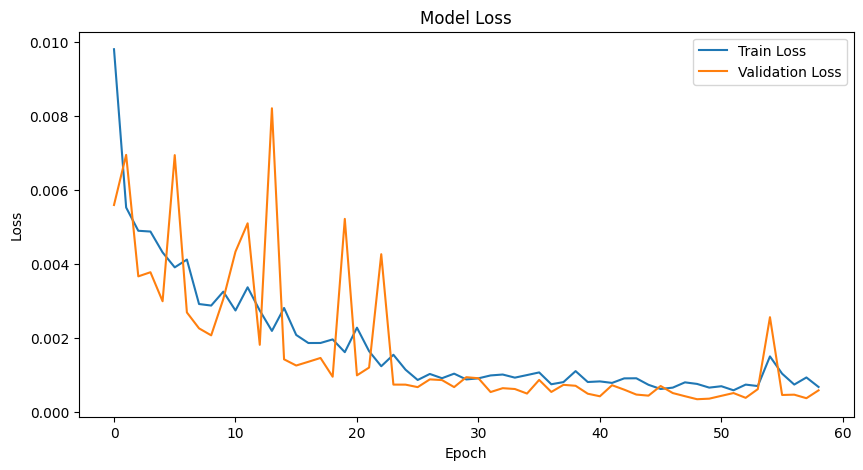

In [ ]:
model = Sequential()
# Conv1D layer for feature extraction
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# FastRNN approximated by a simpler or smaller LSTM layer
model.add(LSTM(50, return_sequences=True))

# Bidirectional LSTM
model.add(Bidirectional(LSTM(50, return_sequences=False)))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

#call back
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping, checkpoint])

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

110/110 [==============================] - 2s 5ms/step


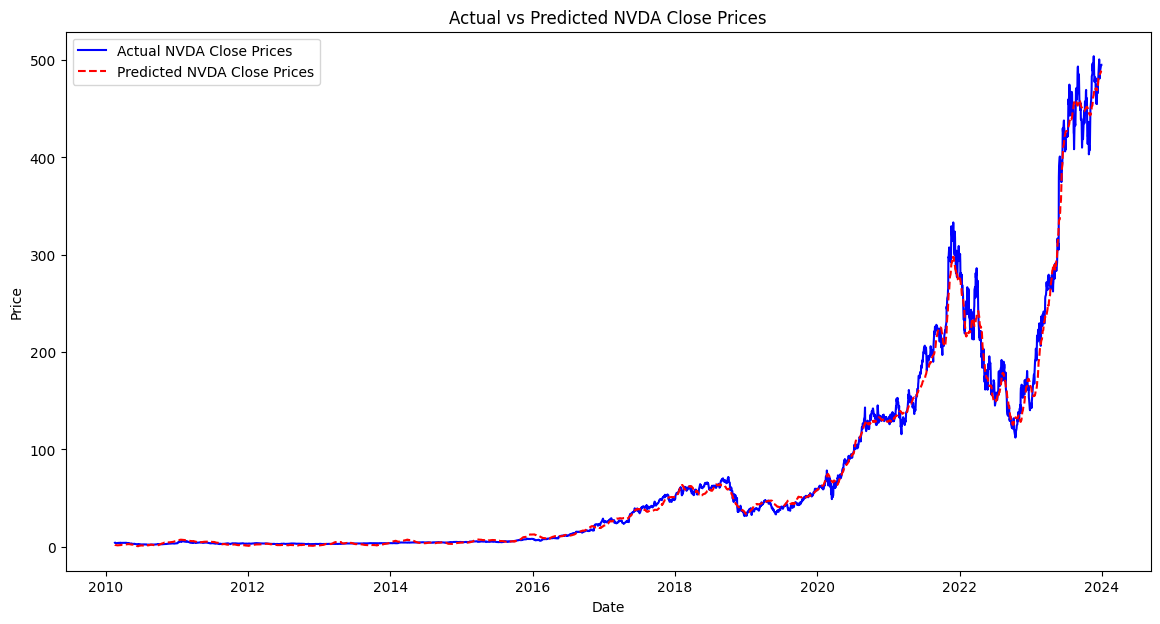

In [ ]:
import matplotlib.pyplot as plt

X_full, y_full = create_dataset(portfolio1_scaled, target_scaled, time_steps)
predictions_full = model.predict(X_full)
predictions_full_inverted = scaler_y.inverse_transform(predictions_full)

# The actual values need to be aligned with the predictions, starting from the end of the first time_step period
actual_values_aligned = target.values[time_steps:]
dates_aligned = target.index[time_steps:]

# Ensure the lengths match after trimming (in case of any indexing issues)
min_length = min(len(predictions_full_inverted), len(actual_values_aligned))
predictions_full_inverted = predictions_full_inverted[:min_length]
actual_values_aligned = actual_values_aligned[:min_length]
dates_aligned = dates_aligned[:min_length]

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(dates_aligned, actual_values_aligned, label='Actual NVDA Close Prices', color='blue')
plt.plot(dates_aligned, predictions_full_inverted, label='Predicted NVDA Close Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted NVDA Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(actual_values_aligned, predictions_full_inverted))
mae = mean_absolute_error(actual_values_aligned, predictions_full_inverted)
mse = mean_squared_error(actual_values_aligned, predictions_full_inverted)
r2 = r2_score(actual_values_aligned, predictions_full_inverted)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f"RMSE: {rmse}")
print(f'Coefficient of Determination (R² score): {r2}')

Mean Absolute Error (MAE): 4.750131858412479
Mean Squared Error (MSE): 79.50970493998246
RMSE: 8.916821459465389
Coefficient of Determination (R² score): 0.9933286376167495


# BiLSTM

Epoch 1/100
70/70 [==============================] - 9s 54ms/step - loss: 0.0092 - val_loss: 0.0068
Epoch 2/100
 3/70 [>.............................] - ETA: 2s - loss: 0.0049

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


70/70 [==============================] - 3s 37ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 3/100
70/70 [==============================] - 2s 34ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 4/100
70/70 [==============================] - 2s 34ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 5/100
70/70 [==============================] - 2s 34ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 6/100
70/70 [==============================] - 2s 35ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 7/100
70/70 [==============================] - 2s 34ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 8/100
70/70 [==============================] - 2s 34ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 9/100
70/70 [==============================] - 2s 33ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 10/100
70/70 [==============================] - 2s 33ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 11/100
70/70 [==============================] - 2s 35ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 12/1

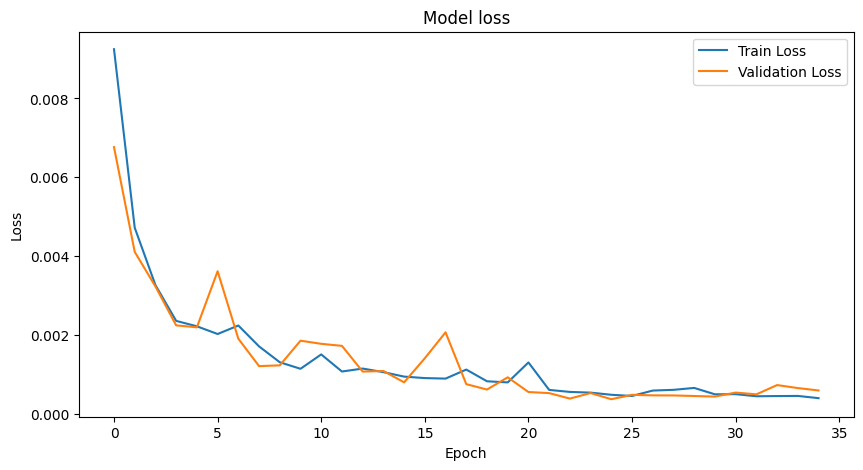

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Function to create a 3D array suitable for LSTM input with extended look-back
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps), :]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

scaler_x = MinMaxScaler(feature_range=(0, 1))
portfolio1_scaled = scaler_x.fit_transform(portfolio1)

scaler_y = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

# Extend time steps for deeper look-back
time_steps = 30  # Increased from 10 to 30 for more historical context
X, y = create_dataset(portfolio1_scaled, target_scaled, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LBL-LSTM model with multiple LSTM layers
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Adding Dropout for regularization
model.add(LSTM(units=50, return_sequences=True))  # Second LSTM layer for deeper analysis
model.add(Dropout(0.2))  # Additional Dropout layer
model.add(LSTM(units=50, return_sequences=False))  # Final LSTM layer to consolidate the information
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Setup callbacks for Early Stopping and best model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model with a suitable number of epochs
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping, checkpoint])

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

110/110 [==============================] - 2s 11ms/step


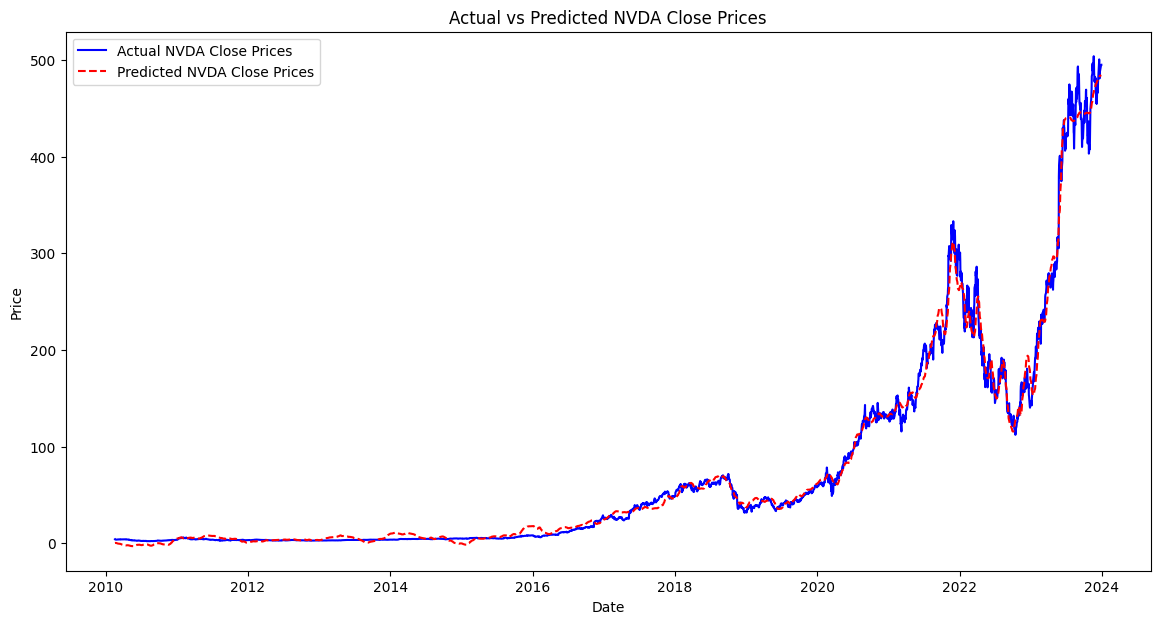

In [ ]:
import matplotlib.pyplot as plt

X_full, y_full = create_dataset(portfolio1_scaled, target_scaled, time_steps=30)  # Ensure time_steps match the model training
predictions_full = model.predict(X_full)
predictions_full_inverted = scaler_y.inverse_transform(predictions_full)

# The actual values need to be aligned with the predictions, starting from the end of the first time_step period
actual_values_aligned = target.values[30:]  # Adjust the index to match the increased time_steps
dates_aligned = target.index[30:]  # Adjust the index to match the increased time_steps

# Ensure the lengths match after trimming (in case of any indexing issues)
min_length = min(len(predictions_full_inverted), len(actual_values_aligned))
predictions_full_inverted = predictions_full_inverted[:min_length]
actual_values_aligned = actual_values_aligned[:min_length]
dates_aligned = dates_aligned[:min_length]

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(dates_aligned, actual_values_aligned, label='Actual NVDA Close Prices', color='blue')
plt.plot(dates_aligned, predictions_full_inverted, label='Predicted NVDA Close Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted NVDA Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(actual_values_aligned, predictions_full_inverted))
mae = mean_absolute_error(actual_values_aligned, predictions_full_inverted)
mse = mean_squared_error(actual_values_aligned, predictions_full_inverted)
r2 = r2_score(actual_values_aligned, predictions_full_inverted)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f"RMSE: {rmse}")
print(f'Coefficient of Determination (R² score): {r2}')

Mean Absolute Error (MAE): 5.630515213049894
Mean Squared Error (MSE): 82.54952187909643
RMSE: 9.085676743044319
Coefficient of Determination (R² score): 0.9930735779307038


# CNN+LSTM

### Find the best hyperparameters


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
71/71 [==============================] - 5s 20ms/step - loss: 0.0128 - val_loss: 0.0058 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
71/71 [==============================] - 1s 8ms/step - loss: 0.0060 - val_loss: 0.0060 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
71/71 [==============================] - 1s 11ms/step - loss: 0.0058 - val_loss: 0.0042 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100
71/71 [==============================] - 1s 10ms/step - loss: 0.0043 - val_loss: 0.0043 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/100
71/71 [==============================] - 1s 9ms/step - loss: 0.0044 - val_loss: 0.0037 - lr: 0.0010

Epoch 6: LearningRateScheduler setti

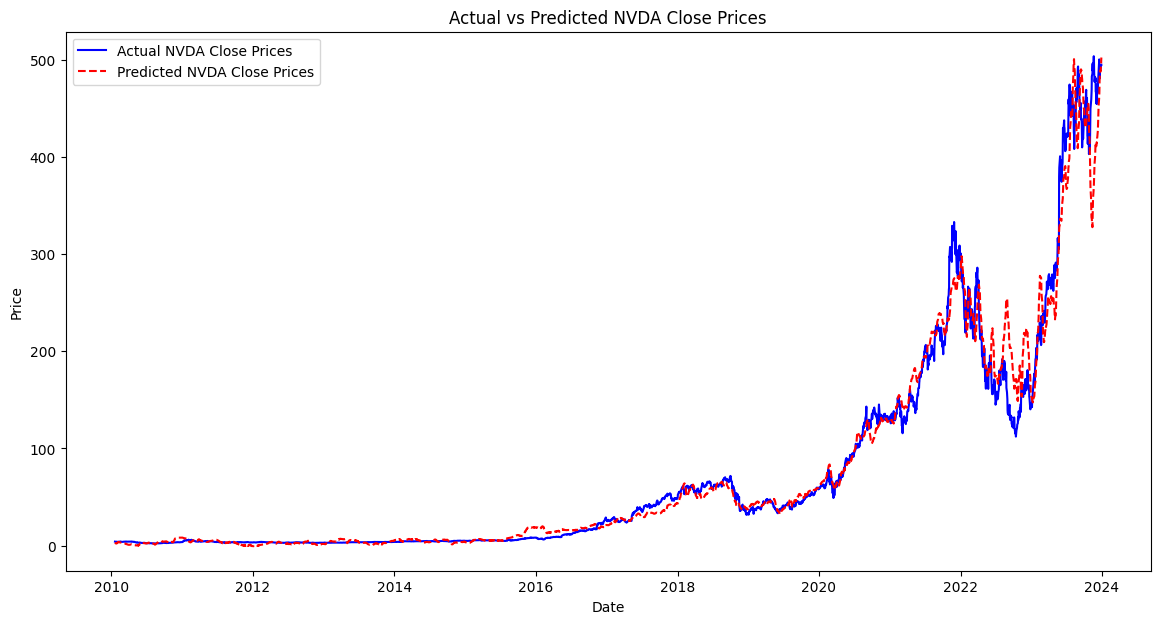

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Function to fetch stock data
def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data

# Fetching stock data for symbols
symbols = ['AMZN', 'GOOG', 'ON', 'FTNT', 'IBM', 'CSCO', 'NVDA']
stock_data = {}
for symbol in symbols:
    stock_data[symbol] = fetch_stock_data(symbol, '2010-01-01', '2024-01-01')

# Combining data
combined_data = pd.concat([stock_data[symbol]['Close'] for symbol in symbols], axis=1)
combined_data.columns = symbols

# Preparing data for modeling
portfolio1 = combined_data.drop('NVDA', axis=1)
target = combined_data['NVDA']

# Scaling the data
scaler_x = MinMaxScaler(feature_range=(0, 1))
portfolio1_scaled = scaler_x.fit_transform(portfolio1)
scaler_y = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

# Function to create dataset suitable for LSTM input
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps), :]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X, y = create_dataset(portfolio1_scaled, target_scaled, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

# CNN+LSTM Model
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dense(units=1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Setup callbacks for early stopping and learning rate scheduling
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    LearningRateScheduler(scheduler, verbose=1)
]

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=callbacks_list)


predictions = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions)
actuals = scaler_y.inverse_transform(y_test)

# Display Predicted vs Actual
print("Predicted vs Actual:")
for i in range(min(5, len(predictions))):
    print(f"Predicted: {predictions[i][0]}, Actual: {actuals[i][0]}")

# Full dataset predictions for plotting
X_full, y_full = create_dataset(portfolio1_scaled, target_scaled, time_steps)
predictions_full = model.predict(X_full)
predictions_full_inverted = scaler_y.inverse_transform(predictions_full)

actual_values_aligned = target.values[time_steps:]
dates_aligned = target.index[time_steps:]

# Plot
plt.figure(figsize=(14, 7))
plt.plot(dates_aligned, actual_values_aligned, label='Actual NVDA Close Prices', color='blue')
plt.plot(dates_aligned, predictions_full_inverted, label='Predicted NVDA Close Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted NVDA Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print("RMSE: ", rmse)
print(f'Coefficient of Determination (R² score): {r2}')

Mean Absolute Error (MAE): 8.02027551489478
Mean Squared Error (MSE): 249.20077919788162
RMSE:  15.786094488437652
Coefficient of Determination (R² score): 0.9740772780644372


## This version is the best


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
71/71 [==============================] - 9s 34ms/step - loss: 0.0101 - val_loss: 0.0055 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
71/71 [==============================] - 1s 11ms/step - loss: 0.0059 - val_loss: 0.0046 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
71/71 [==============================] - 1s 11ms/step - loss: 0.0051 - val_loss: 0.0041 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100
71/71 [==============================] - 1s 11ms/step - loss: 0.0042 - val_loss: 0.0037 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/100
71/71 [==============================] - 1s 11ms/step - loss: 0.0041 - val_loss: 0.0033 - lr: 0.0010

Epoch 6: LearningRateScheduler set

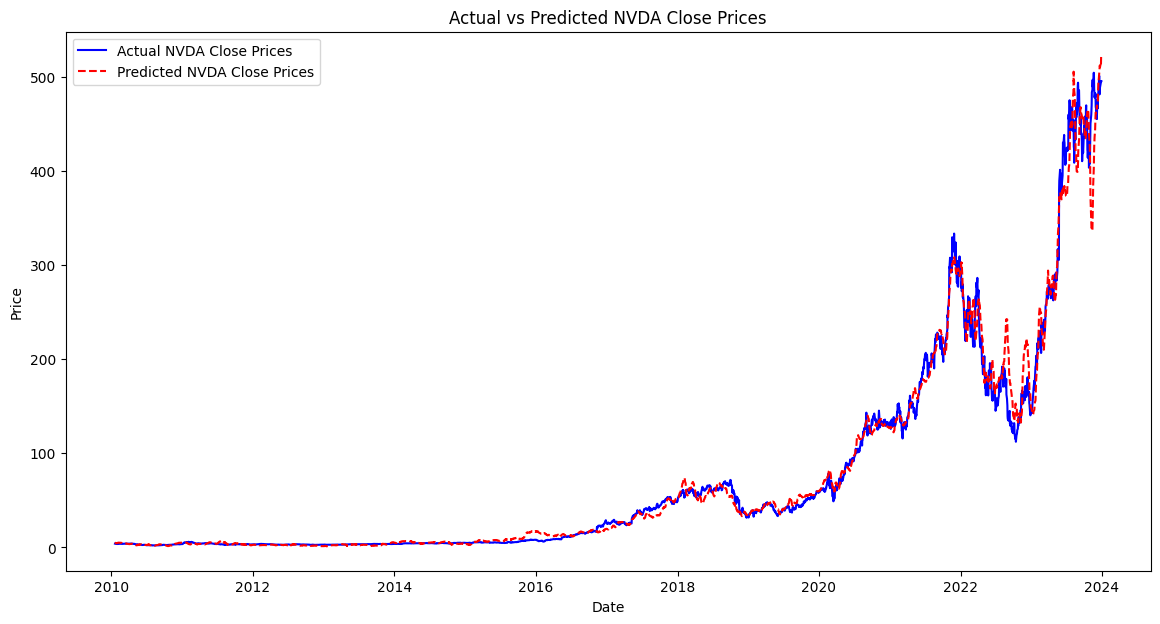

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Function to fetch stock data
def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data

# Fetching stock data for symbols
symbols = ['AMZN', 'GOOG', 'ON', 'FTNT', 'IBM', 'CSCO', 'NVDA']
stock_data = {}
for symbol in symbols:
    stock_data[symbol] = fetch_stock_data(symbol, '2010-01-01', '2024-01-01')

# Combining data
combined_data = pd.concat([stock_data[symbol]['Close'] for symbol in symbols], axis=1)
combined_data.columns = symbols

# Preparing data for modeling
portfolio1 = combined_data.drop('NVDA', axis=1)
target = combined_data['NVDA']

# Scaling the data
scaler_x = MinMaxScaler(feature_range=(0, 1))
portfolio1_scaled = scaler_x.fit_transform(portfolio1)
scaler_y = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

# Function to create dataset suitable for LSTM input
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps), :]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X, y = create_dataset(portfolio1_scaled, target_scaled, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

# CNN+Bidirectional LSTM Model
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Bidirectional(LSTM(units=100, return_sequences=True, activation='tanh')),
    Dropout(0.3),
    Bidirectional(LSTM(units=50, activation='tanh')),
    Dense(units=1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Setup callbacks for early stopping and learning rate scheduling
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    LearningRateScheduler(scheduler, verbose=1)
]

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=callbacks_list)

predictions = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions)
actuals = scaler_y.inverse_transform(y_test)

# Display Predicted vs Actual
print("Predicted vs Actual:")
for i in range(min(5, len(predictions))):
    print(f"Predicted: {predictions[i][0]}, Actual: {actuals[i][0]}")

# Full dataset predictions for plotting
X_full, y_full = create_dataset(portfolio1_scaled, target_scaled, time_steps)
predictions_full = model.predict(X_full)
predictions_full_inverted = scaler_y.inverse_transform(predictions_full)

# Aligning actual values and dates for plotting
actual_values_aligned = target.values[time_steps:]
dates_aligned = target.index[time_steps:]

# Plot
plt.figure(figsize=(14, 7))
plt.plot(dates_aligned, actual_values_aligned, label='Actual NVDA Close Prices', color='blue')
plt.plot(dates_aligned, predictions_full_inverted, label='Predicted NVDA Close Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted NVDA Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print("RMSE: ", rmse)
print(f'Coefficient of Determination (R² score): {r2}')

Mean Absolute Error (MAE): 6.038846004229691
Mean Squared Error (MSE): 146.40677586454527
RMSE:  12.099866770528726
Coefficient of Determination (R² score): 0.9847702636711946


## Old Version of CNN+LSTM

Epoch 1/5
71/71 [==============================] - 7s 43ms/step - loss: 0.0247 - val_loss: 0.0063
Epoch 2/5
71/71 [==============================] - 0s 7ms/step - loss: 0.0049 - val_loss: 0.0054
Epoch 3/5
71/71 [==============================] - 0s 7ms/step - loss: 0.0040 - val_loss: 0.0052
Epoch 4/5
71/71 [==============================] - 0s 6ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 5/5
22/22 [==============================] - 1s 2ms/step
Predicted vs Actual:
Predicted: -3.9860594272613525, Actual: 3.256422996520996
Predicted: 5.508197784423828, Actual: 10.333990097045898
Predicted: 32.30366897583008, Actual: 44.58513641357422
Predicted: 7.420231819152832, Actual: 7.597283363342285
Predicted: 128.41273498535156, Actual: 136.81024169921875
110/110 [==============================] - 0s 2ms/step


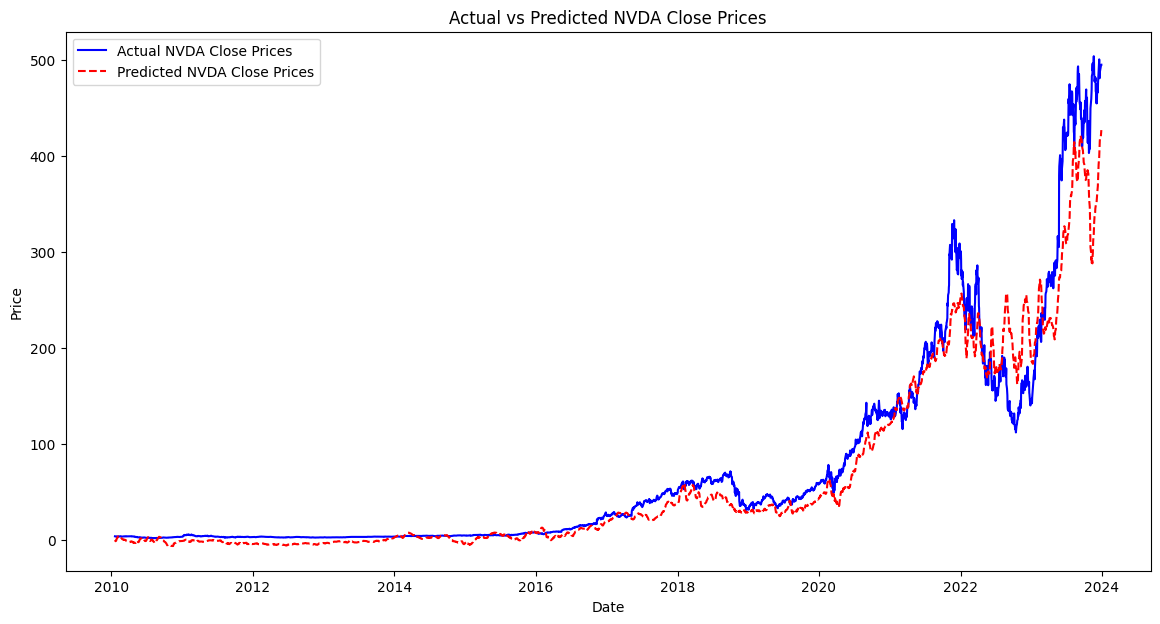

In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

symbols = ['AMZN', 'GOOG', 'ON', 'FTNT', 'IBM', 'CSCO', 'NVDA']

# Function to fetch stock data
def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data

# Fetching stock data
stock_data = {}
for symbol in symbols:
    stock_data[symbol] = fetch_stock_data(symbol, '2010-01-01', '2024-01-01')

combined_data = pd.concat([stock_data[symbol]['Close'] for symbol in symbols], axis=1)
combined_data.columns = symbols

# Preparing data for modeling
portfolio1 = combined_data.drop('NVDA', axis=1)
target = combined_data['NVDA']

# Scaling the data
scaler_x = MinMaxScaler(feature_range=(0, 1))
portfolio1_scaled = scaler_x.fit_transform(portfolio1)

scaler_y = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

# Function to create dataset suitable for LSTM input
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps), :]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X, y = create_dataset(portfolio1_scaled, target_scaled, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CNN+LSTM Model
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(units=50),
    Dense(units=1)
])


model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

predictions = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions)  # Invert scaling for predictions
actuals = scaler_y.inverse_transform(y_test)  # Invert scaling for actual values

# Display Predicted vs Actual
print("Predicted vs Actual:")
for i in range(min(5, len(predictions))):
    print(f"Predicted: {predictions[i][0]}, Actual: {actuals[i][0]}")

# Full dataset predictions for plotting
X_full, y_full = create_dataset(portfolio1_scaled, target_scaled, time_steps)
predictions_full = model.predict(X_full)
predictions_full_inverted = scaler_y.inverse_transform(predictions_full)

# Aligning actual values and dates for plotting
actual_values_aligned = target.values[time_steps:]
dates_aligned = target.index[time_steps:]

# Plot
plt.figure(figsize=(14, 7))
plt.plot(dates_aligned, actual_values_aligned, label='Actual NVDA Close Prices', color='blue')
plt.plot(dates_aligned, predictions_full_inverted, label='Predicted NVDA Close Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted NVDA Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print("RMSE: ", rmse)
print(f'Coefficient of Determination (R² score): {r2}')

Mean Absolute Error (MAE): 14.532763800442028
Mean Squared Error (MSE): 656.2482450618556
RMSE:  25.617342661990833
Coefficient of Determination (R² score): 0.9317348014740137


# CNN+GRU

## Find the best hyperparameters


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
71/71 [==============================] - 6s 22ms/step - loss: 0.0134 - val_loss: 0.0088 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
71/71 [==============================] - 1s 9ms/step - loss: 0.0063 - val_loss: 0.0084 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
71/71 [==============================] - 1s 8ms/step - loss: 0.0058 - val_loss: 0.0068 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100
71/71 [==============================] - 1s 8ms/step - loss: 0.0053 - val_loss: 0.0041 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/100
71/71 [==============================] - 1s 8ms/step - loss: 0.0047 - val_loss: 0.0047 - lr: 0.0010

Epoch 6: LearningRateScheduler setting

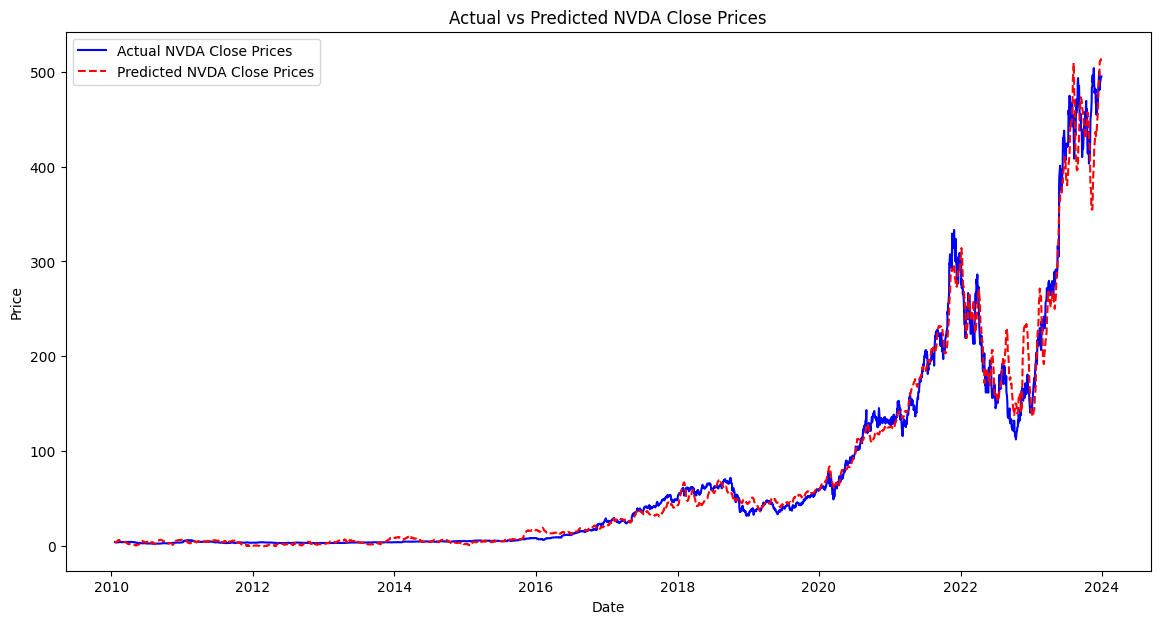

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data

# Function to create dataset suitable for GRU input
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps), :]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Fetching and combining stock data
symbols = ['AMZN', 'GOOG', 'ON', 'FTNT', 'IBM', 'CSCO', 'NVDA']
stock_data = {symbol: fetch_stock_data(symbol, '2010-01-01', '2024-01-01') for symbol in symbols}
combined_data = pd.concat([stock_data[symbol]['Close'] for symbol in symbols], axis=1)
combined_data.columns = symbols

# Preprocessing and scaling data
portfolio1 = combined_data.drop('NVDA', axis=1)
target = combined_data['NVDA']
scaler_x = MinMaxScaler(feature_range=(0, 1))
portfolio1_scaled = scaler_x.fit_transform(portfolio1)
scaler_y = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

time_steps = 10
X, y = create_dataset(portfolio1_scaled, target_scaled, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

# CNN+GRU Model with optimizations
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),  # Dropout for regularization
    GRU(units=50, return_sequences=True),
    Dropout(0.2),
    GRU(units=50),
    Dense(units=1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Setup callbacks for early stopping and learning rate scheduling
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    LearningRateScheduler(scheduler, verbose=1)
]

# Training the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=callbacks_list)

# Generating and displaying predictions
predictions = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions)
actuals = scaler_y.inverse_transform(y_test)
print("Predicted vs Actual:")
for i in range(min(5, len(predictions))):
    print(f"Predicted: {predictions[i][0]}, Actual: {actuals[i][0]}")

# Full dataset predictions for plotting
X_full, y_full = create_dataset(portfolio1_scaled, target_scaled, time_steps)
predictions_full = model.predict(X_full)
predictions_full_inverted = scaler_y.inverse_transform(predictions_full)
actual_values_aligned = target.values[time_steps:]
dates_aligned = target.index[time_steps:]

# Plotting results
plt.figure(figsize=(14, 7))
plt.plot(dates_aligned, actual_values_aligned, label='Actual NVDA Close Prices', color='blue')
plt.plot(dates_aligned, predictions_full_inverted, label='Predicted NVDA Close Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted NVDA Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print("RMSE: ", rmse)
print(f'Coefficient of Determination (R² score): {r2}')

Mean Absolute Error (MAE): 7.280541626063532
Mean Squared Error (MSE): 180.01486784269355
RMSE:  13.416961945339695
Coefficient of Determination (R² score): 0.9812742344611702


## Try new model complexity


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
71/71 [==============================] - 11s 34ms/step - loss: 0.0468 - val_loss: 0.0566 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
71/71 [==============================] - 1s 14ms/step - loss: 0.0126 - val_loss: 0.0434 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
71/71 [==============================] - 1s 14ms/step - loss: 0.0093 - val_loss: 0.0464 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100
71/71 [==============================] - 1s 14ms/step - loss: 0.0087 - val_loss: 0.0267 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/100
71/71 [==============================] - 1s 13ms/step - loss: 0.0063 - val_loss: 0.0268 - lr: 0.0010

Epoch 6: LearningRateScheduler se

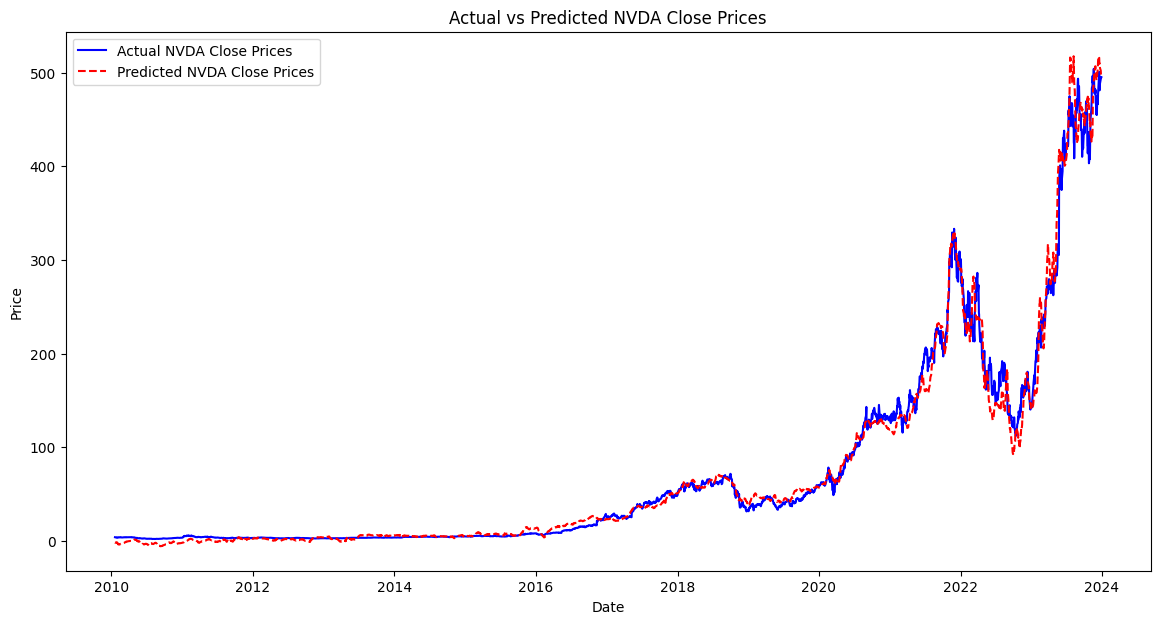

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Conv1D, MaxPooling1D, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data

symbols = ['AMZN', 'GOOG', 'ON', 'FTNT', 'IBM', 'CSCO', 'NVDA']
stock_data = {symbol: fetch_stock_data(symbol, '2010-01-01', '2024-01-01') for symbol in symbols}
combined_data = pd.concat([stock_data[symbol]['Close'] for symbol in symbols], axis=1)
combined_data.columns = symbols

# Preprocessing and scaling data
portfolio1 = combined_data.drop('NVDA', axis=1)
target = combined_data['NVDA']
scaler_x = MinMaxScaler(feature_range=(0, 1))
portfolio1_scaled = scaler_x.fit_transform(portfolio1)
scaler_y = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

time_steps = 10
X, y = create_dataset(portfolio1_scaled, target_scaled, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

# CNN+Bidirectional GRU Model with optimizations
model = Sequential([
    Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(GRU(units=100, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(GRU(units=50)),
    Dense(units=1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Setup callbacks for early stopping and learning rate scheduling
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    LearningRateScheduler(scheduler, verbose=1)
]

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=callbacks_list)

# Generating and displaying predictions
predictions = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions)
actuals = scaler_y.inverse_transform(y_test)
print("Predicted vs Actual:")
for i in range(min(5, len(predictions))):
    print(f"Predicted: {predictions[i][0]}, Actual: {actuals[i][0]}")

# Full dataset predictions for plotting
X_full, y_full = create_dataset(portfolio1_scaled, target_scaled, time_steps)
predictions_full = model.predict(X_full)
predictions_full_inverted = scaler_y.inverse_transform(predictions_full)
actual_values_aligned = target.values[time_steps:]
dates_aligned = target.index[time_steps:]

# Plotting results
plt.figure(figsize=(14, 7))
plt.plot(dates_aligned, actual_values_aligned, label='Actual NVDA Close Prices', color='blue')
plt.plot(dates_aligned, predictions_full_inverted, label='Predicted NVDA Close Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted NVDA Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print("RMSE: ", rmse)
print(f'Coefficient of Determination (R² score): {r2}')

Mean Absolute Error (MAE): 7.026851505952573
Mean Squared Error (MSE): 151.9065562785116
RMSE:  12.325037780003418
Coefficient of Determination (R² score): 0.9841981575983956


## Old Version of CNN + GRU

Epoch 1/5
71/71 [==============================] - 5s 22ms/step - loss: 0.0083 - val_loss: 0.0059
Epoch 2/5
71/71 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 3/5
71/71 [==============================] - 0s 6ms/step - loss: 0.0041 - val_loss: 0.0051
Epoch 4/5
71/71 [==============================] - 0s 6ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 5/5
22/22 [==============================] - 0s 2ms/step
Predicted vs Actual:
Predicted: 3.0359113216400146, Actual: 3.256422996520996
Predicted: 3.766894817352295, Actual: 10.333990097045898
Predicted: 46.203269958496094, Actual: 44.58513641357422
Predicted: 5.826996326446533, Actual: 7.597283363342285
Predicted: 131.49266052246094, Actual: 136.81024169921875
110/110 [==============================] - 0s 2ms/step


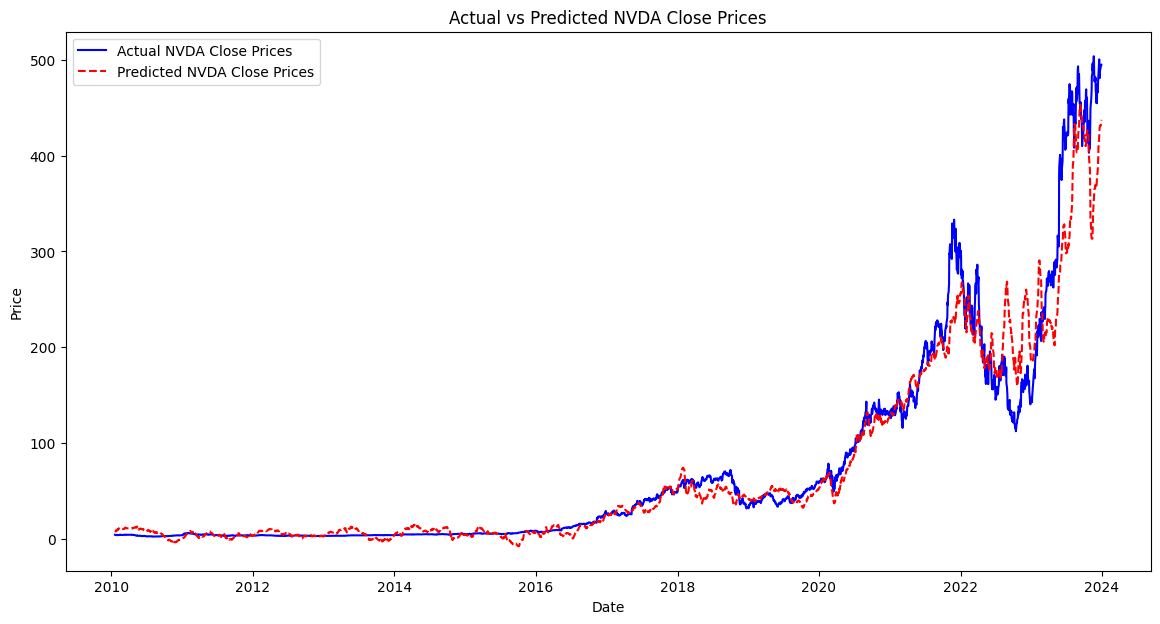

In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Conv1D, MaxPooling1D, Flatten
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


symbols = ['AMZN', 'GOOG', 'ON', 'FTNT', 'IBM', 'CSCO', 'NVDA']
stock_data = {}
for symbol in symbols:
    stock_data[symbol] = fetch_stock_data(symbol, '2010-01-01', '2024-01-01')

# Preprocessing and scaling your data
combined_data = pd.concat([stock_data[symbol]['Close'] for symbol in symbols], axis=1)
combined_data.columns = symbols
portfolio1 = combined_data.drop('NVDA', axis=1)
target = combined_data['NVDA']

scaler_x = MinMaxScaler(feature_range=(0, 1))
portfolio1_scaled = scaler_x.fit_transform(portfolio1)

scaler_y = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

time_steps = 10
X, y = create_dataset(portfolio1_scaled, target_scaled, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CNN+GRU Model definition
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    GRU(units=50),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Generating predictions
predictions = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions)  # Invert scaling for predictions
actuals = scaler_y.inverse_transform(y_test)  # Invert scaling for actual values

# Display Predicted vs Actual
print("Predicted vs Actual:")
for i in range(min(5, len(predictions))):
    print(f"Predicted: {predictions[i][0]}, Actual: {actuals[i][0]}")

# Full dataset predictions for plotting
X_full, y_full = create_dataset(portfolio1_scaled, target_scaled, time_steps)
predictions_full = model.predict(X_full)
predictions_full_inverted = scaler_y.inverse_transform(predictions_full)

# Aligning actual values and dates for plotting
actual_values_aligned = target.values[time_steps:]
dates_aligned = target.index[time_steps:]

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(dates_aligned, actual_values_aligned, label='Actual NVDA Close Prices', color='blue')
plt.plot(dates_aligned, predictions_full_inverted, label='Predicted NVDA Close Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted NVDA Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print("RMSE: ", rmse)
print(f'Coefficient of Determination (R² score): {r2}')

Mean Absolute Error (MAE): 12.27617202612941
Mean Squared Error (MSE): 627.8210432776115
RMSE:  25.056357342551042
Coefficient of Determination (R² score): 0.9346918967317035


# lstm + gru

## The best model of all

Epoch 1/100
71/71 [==============================] - 6s 31ms/step - loss: 0.0088 - val_loss: 0.0073 - lr: 0.0010
Epoch 2/100
71/71 [==============================] - 1s 19ms/step - loss: 0.0067 - val_loss: 0.0058 - lr: 0.0010
Epoch 3/100
71/71 [==============================] - 1s 17ms/step - loss: 0.0040 - val_loss: 0.0031 - lr: 0.0010
Epoch 4/100
71/71 [==============================] - 1s 17ms/step - loss: 0.0036 - val_loss: 0.0030 - lr: 0.0010
Epoch 5/100
71/71 [==============================] - 1s 17ms/step - loss: 0.0040 - val_loss: 0.0026 - lr: 0.0010
Epoch 6/100
71/71 [==============================] - 1s 18ms/step - loss: 0.0030 - val_loss: 0.0063 - lr: 0.0010
Epoch 7/100
71/71 [==============================] - 1s 17ms/step - loss: 0.0028 - val_loss: 0.0033 - lr: 0.0010
Epoch 8/100
71/71 [==============================] - 1s 17ms/step - loss: 0.0021 - val_loss: 0.0026 - lr: 0.0010
Epoch 9/100
71/71 [==============================] - 1s 17ms/step - loss: 0.0024 - val_loss: 0.0

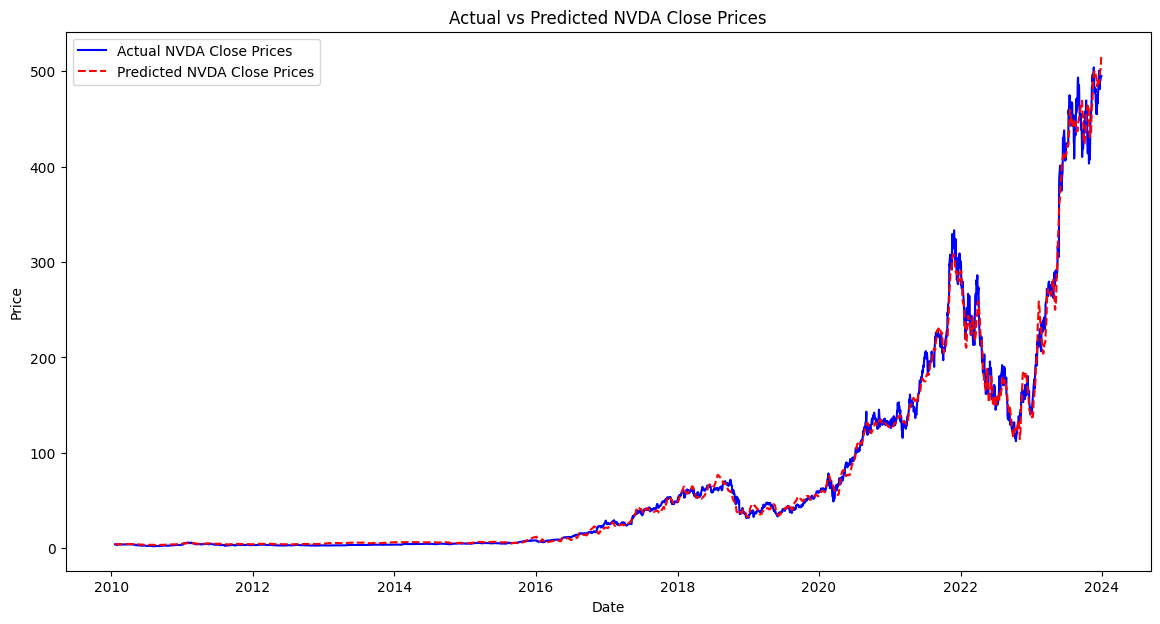

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data

# Function to create dataset suitable for GRU input
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps), :]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Fetching and combining stock data
symbols = ['AMZN', 'GOOG', 'ON', 'FTNT', 'IBM', 'CSCO', 'NVDA']
stock_data = {symbol: fetch_stock_data(symbol, '2010-01-01', '2024-01-01') for symbol in symbols}
combined_data = pd.concat([stock_data[symbol]['Close'] for symbol in symbols], axis=1)
combined_data.columns = symbols

# Preprocessing and scaling data
portfolio1 = combined_data.drop('NVDA', axis=1)
target = combined_data['NVDA']
scaler_x = MinMaxScaler(feature_range=(0, 1))
portfolio1_scaled = scaler_x.fit_transform(portfolio1)
scaler_y = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

time_steps = 10
X, y = create_dataset(portfolio1_scaled, target_scaled, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


time_steps = 10
X, y = create_dataset(portfolio1_scaled, target_scaled, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# GRU+LSTM Model
model = Sequential([
    GRU(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping, reduce_lr])

predictions = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions)

actuals = scaler_y.inverse_transform(y_test)

print("Predicted vs Actual:")
for i in range(min(5, len(predictions))):
    print(f"Predicted: {predictions[i][0]}, Actual: {actuals[i][0]}")

X_full, y_full = create_dataset(portfolio1_scaled, target_scaled, time_steps)
predictions_full = model.predict(X_full)
predictions_full_inverted = scaler_y.inverse_transform(predictions_full)

actual_values_aligned = target.values[time_steps:]
dates_aligned = target.index[time_steps:]

plt.figure(figsize=(14, 7))
plt.plot(dates_aligned, actual_values_aligned, label='Actual NVDA Close Prices', color='blue')
plt.plot(dates_aligned, predictions_full_inverted, label='Predicted NVDA Close Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted NVDA Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print("RMSE: ", rmse)
print(f'Coefficient of Determination (R² score): {r2}')

Mean Absolute Error (MAE): 4.521337599706853
Mean Squared Error (MSE): 66.41000972129612
RMSE:  8.149233689206374
Coefficient of Determination (R² score): 0.9930918024362348


## Try new model combinations

Epoch 1/100
71/71 [==============================] - 21s 124ms/step - loss: 0.0115 - val_loss: 0.0086 - lr: 0.0010
Epoch 2/100
71/71 [==============================] - 7s 98ms/step - loss: 0.0053 - val_loss: 0.0060 - lr: 0.0010
Epoch 3/100
71/71 [==============================] - 7s 99ms/step - loss: 0.0054 - val_loss: 0.0035 - lr: 0.0010
Epoch 4/100
71/71 [==============================] - 7s 95ms/step - loss: 0.0042 - val_loss: 0.0052 - lr: 0.0010
Epoch 5/100
71/71 [==============================] - 7s 99ms/step - loss: 0.0050 - val_loss: 0.0025 - lr: 0.0010
Epoch 6/100
71/71 [==============================] - 7s 96ms/step - loss: 0.0057 - val_loss: 0.0027 - lr: 0.0010
Epoch 7/100
71/71 [==============================] - 7s 103ms/step - loss: 0.0029 - val_loss: 0.0026 - lr: 0.0010
Epoch 8/100
71/71 [==============================] - 7s 96ms/step - loss: 0.0030 - val_loss: 0.0032 - lr: 0.0010
Epoch 9/100
71/71 [==============================] - 7s 100ms/step - loss: 0.0029 - val_loss:

ValueError: x and y must have same first dimension, but have shapes (693,) and (703, 1)

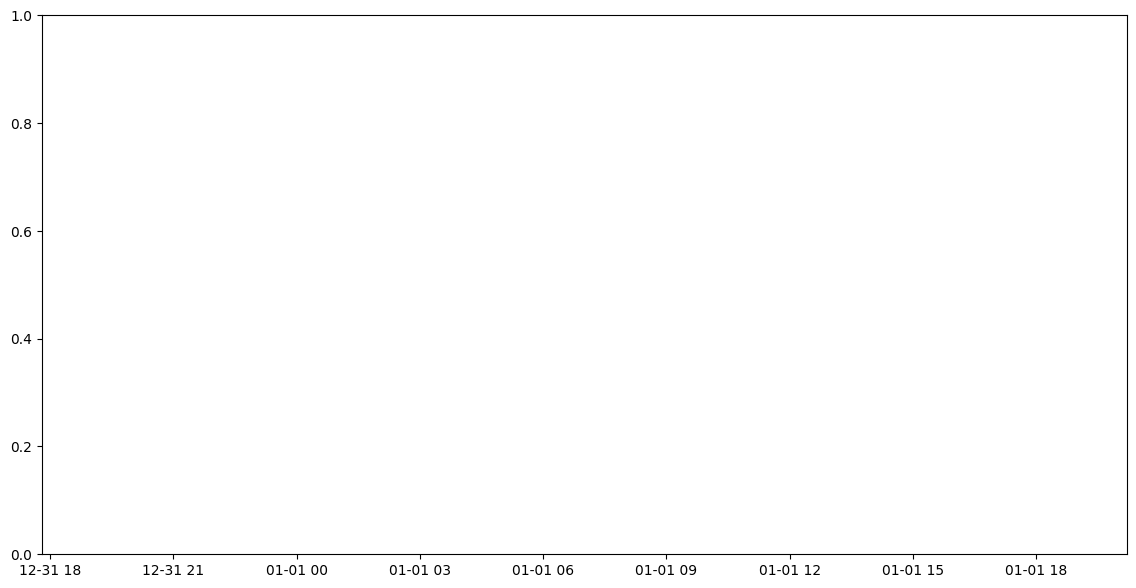

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data

# Function to create dataset
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps), :]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Load and preprocess data
symbols = ['AMZN', 'GOOG', 'ON', 'FTNT', 'IBM', 'CSCO', 'NVDA']
stock_data = {symbol: fetch_stock_data(symbol, '2010-01-01', '2024-01-01') for symbol in symbols}
combined_data = pd.concat([stock_data[symbol]['Close'] for symbol in symbols], axis=1)
combined_data.columns = symbols

portfolio1 = combined_data.drop('NVDA', axis=1)
target = combined_data['NVDA']
scaler_x = MinMaxScaler(feature_range=(0, 1))
portfolio1_scaled = scaler_x.fit_transform(portfolio1)
scaler_y = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

# Create dataset
time_steps = 10
X, y = create_dataset(portfolio1_scaled, target_scaled, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model configuration
model = Sequential([
    Bidirectional(GRU(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(X_train.shape[1], X_train.shape[2]))),
    Bidirectional(LSTM(256, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),
    Dense(128, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Model training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping, reduce_lr])

# Prediction and evaluation
predictions = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions)
predictions = predictions.flatten()

actuals = scaler_y.inverse_transform(y_test)

rmse = sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

# Output results
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print("Root Mean Squared Error (RMSE): ", rmse)
print(f'Coefficient of Determination (R² score): {r2}')

# Plotting
test_dates = target.index[time_steps:][len(target) - len(predictions):]  # Correct date indices for the test set
plt.figure(figsize=(14, 7))
plt.plot(test_dates, actuals, label='Actual NVDA Close Prices', color='blue')
plt.plot(test_dates, predictions, label='Predicted NVDA Close Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted NVDA Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()




---



---



---



---



---



---



Epoch 1/100
88/88 [==============================] - 4s 16ms/step - loss: 0.0011 - val_loss: 0.0447
Epoch 2/100
88/88 [==============================] - 1s 9ms/step - loss: 1.0229e-04 - val_loss: 0.0388
Epoch 3/100
88/88 [==============================] - 1s 9ms/step - loss: 5.7590e-05 - val_loss: 0.0406
Epoch 4/100
88/88 [==============================] - 1s 9ms/step - loss: 4.1848e-05 - val_loss: 0.0424
Epoch 5/100
88/88 [==============================] - 1s 9ms/step - loss: 3.2797e-05 - val_loss: 0.0368
Epoch 6/100
88/88 [==============================] - 1s 10ms/step - loss: 2.8168e-05 - val_loss: 0.0291
Epoch 7/100
88/88 [==============================] - 1s 10ms/step - loss: 2.5108e-05 - val_loss: 0.0279
Epoch 8/100
88/88 [==============================] - 1s 10ms/step - loss: 2.6315e-05 - val_loss: 0.0274
Epoch 9/100
88/88 [==============================] - 1s 10ms/step - loss: 2.3188e-05 - val_loss: 0.0226
Epoch 10/100
88/88 [==============================] - 1s 10ms/step - los

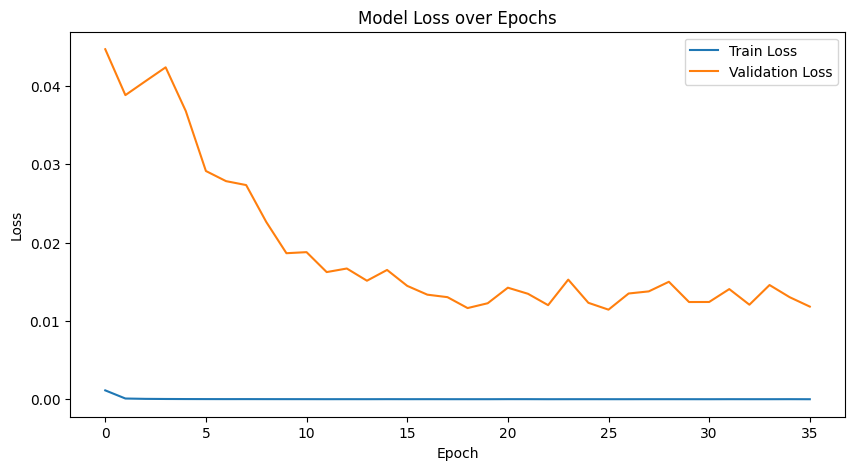

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data['Close']

# Define the symbols and the date range for fetching training data
symbols = ['AMZN', 'GOOG', 'ON', 'FTNT', 'IBM', 'CSCO', 'NVDA']
train_start_date = '2010-01-01'
train_end_date = '2023-12-31'

# Fetch and store training stock data
stock_data_train = {symbol: fetch_stock_data(symbol, train_start_date, train_end_date) for symbol in symbols}

# Combine the training closing prices into one DataFrame
combined_data_train = pd.concat(stock_data_train, axis=1)

# Normalize features using training data scaler
scaler_x = MinMaxScaler(feature_range=(0, 1))
features_train_scaled = scaler_x.fit_transform(combined_data_train)

scaler_y = MinMaxScaler(feature_range=(0, 1))
target_train_scaled = scaler_y.fit_transform(combined_data_train[['NVDA']])

# Function to create dataset for LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps), :]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Predicting using a number of days for input
time_steps = 10
X_train, y_train = create_dataset(features_train_scaled, target_train_scaled, time_steps)

# Build the LSTM model
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model using training data
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

test_start_date = '2024-01-02'
test_end_date = '2024-04-30'

# Fetch and store test stock data for Nvidia only
nvda_test_data = fetch_stock_data('NVDA', test_start_date, test_end_date)

# Prepare Nvidia's test data correctly by ensuring the column name matches
nvda_test_data_frame = nvda_test_data.to_frame()
nvda_test_data_frame.columns = ['NVDA']

nvda_test_data_scaled = scaler_y.transform(nvda_test_data_frame)
X_test, y_test = create_dataset(features_train_scaled[-len(nvda_test_data):], nvda_test_data_scaled, time_steps)  # Using the latest available full features to predict future steps

# Evaluate the model using the Nvidia-only test data
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

110/110 [==============================] - 1s 4ms/step


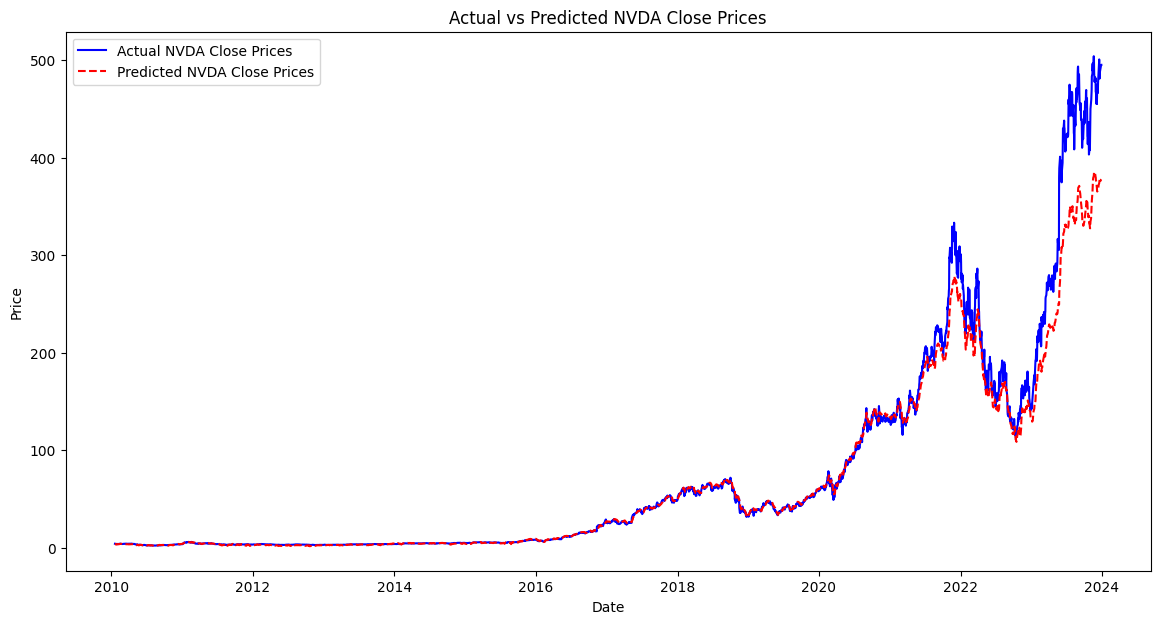

In [ ]:
import matplotlib.pyplot as plt

# Generate predictions for the entire training dataset
X_full, y_full = create_dataset(features_train_scaled, target_train_scaled, time_steps)
predictions_full = model.predict(X_full)
predictions_full_inverted = scaler_y.inverse_transform(predictions_full)

# The actual values need to be aligned with the predictions, starting from the end of the first time_step period
actual_values_aligned = combined_data_train['NVDA'].values[time_steps:]
dates_aligned = combined_data_train.index[time_steps:]

# Ensure the lengths match after trimming (in case of any indexing issues)
min_length = min(len(predictions_full_inverted), len(actual_values_aligned))
predictions_full_inverted = predictions_full_inverted[:min_length]
actual_values_aligned = actual_values_aligned[:min_length]
dates_aligned = dates_aligned[:min_length]

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(dates_aligned, actual_values_aligned, label='Actual NVDA Close Prices', color='blue')
plt.plot(dates_aligned, predictions_full_inverted, label='Predicted NVDA Close Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted NVDA Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# SVM + Logistic regression

In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Fetch stock data
def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data['Close']

symbols = ['AMZN', 'GOOG', 'ON', 'FTNT', 'IBM', 'CSCO', 'NVDA']
start_date = '2010-01-01'
end_date = '2024-01-01'

stock_data = {}
for symbol in symbols:
    stock_data[symbol] = fetch_stock_data(symbol, start_date, end_date)

combined_data = pd.concat(stock_data, axis=1)
combined_data.columns = symbols

# Prepare data for modeling
X = combined_data.drop('NVDA', axis=1)
y = combined_data['NVDA']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM model
svm_model = SVR(kernel='linear')
svm_model.fit(X_train_scaled, y_train)
svm_predictions = svm_model.predict(X_test_scaled)
svm_mse = mean_squared_error(y_test, svm_predictions)
print("SVM MSE:", svm_mse)

# Logistic Regression model (for classification, needs binarized y)
# Assuming a simplistic binarization for demonstration: price up (1) or not (0)
y_train_bin = (y_train > y_train.shift(1)).astype(int)
y_test_bin = (y_test > y_test.shift(1)).astype(int)
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train_scaled, y_train_bin)
log_reg_accuracy = log_reg_model.score(X_test_scaled, y_test_bin)
print("Logistic Regression Accuracy:", log_reg_accuracy)

SVM MSE: 1328.8671812087211
Logistic Regression Accuracy: 0.7390070921985815


### SVM-Logistic(RandomSearch)-High Accuracy(suspicious)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
SVM MSE: 60.44235565550966
SVM RMSE: 7.774468191169713


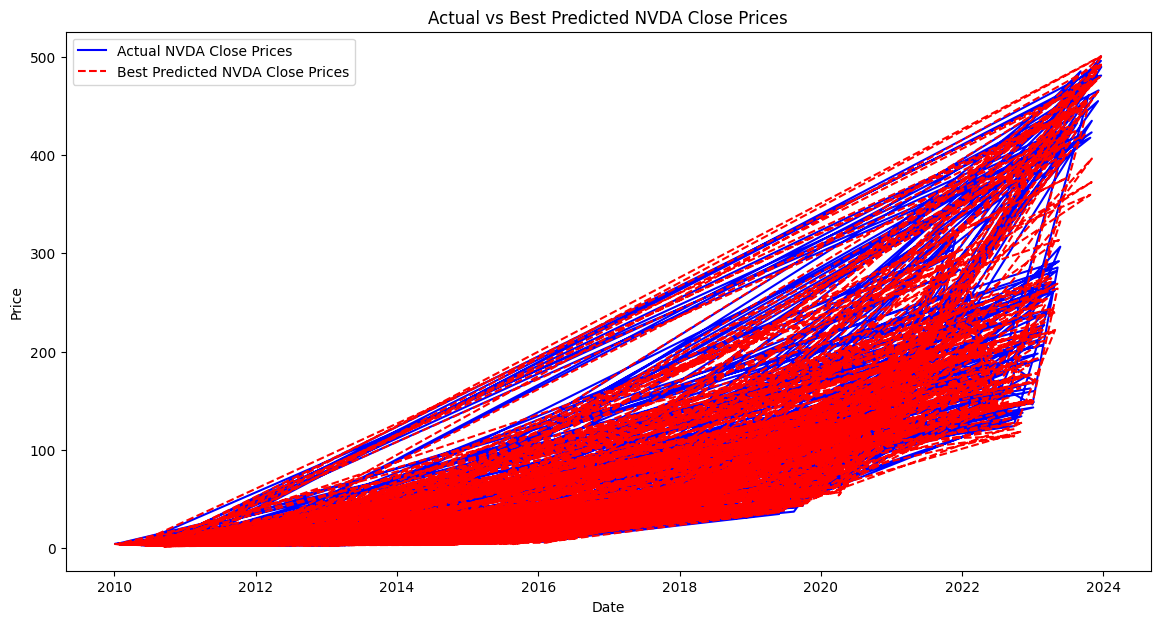

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Fetch stock data
def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data['Close']

symbols = ['AMZN', 'GOOG', 'ON', 'FTNT', 'IBM', 'CSCO', 'NVDA']
start_date = '2010-01-01'
end_date = '2024-01-01'

stock_data = {}
for symbol in symbols:
    stock_data[symbol] = fetch_stock_data(symbol, start_date, end_date)

combined_data = pd.concat(stock_data, axis=1)
combined_data.columns = symbols

# Prepare data for modeling
X = combined_data.drop('NVDA', axis=1)
y = combined_data['NVDA']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM model with RandomizedSearchCV
params = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}
svm_random = RandomizedSearchCV(SVR(), params, n_iter=10, cv=5, scoring='neg_mean_squared_error', verbose=1, random_state=42)
svm_random.fit(X_train_scaled, y_train)

best_svr = svm_random.best_estimator_
svm_predictions = best_svr.predict(X_test_scaled)
svm_mse = mean_squared_error(y_test, svm_predictions)
svm_rmse = np.sqrt(svm_mse)

print("SVM MSE:", svm_mse)
print("SVM RMSE:", svm_rmse)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual NVDA Close Prices', color='blue')
plt.plot(y_test.index, svm_predictions, label='Best Predicted NVDA Close Prices', color='red', linestyle='--')
plt.title('Actual vs Best Predicted NVDA Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

——————————————————————————————————————————————————

In [ ]:
import yfinance as yf
import pandas as pd

symbols = ['AMZN', 'MSFT', 'AAPL', 'GM', 'TSLA', 'WMT']

start_date = '2010-01-01'
end_date = '2024-01-01'

def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data

stock_data = {}
for symbol in symbols:
    stock_data[symbol] = fetch_stock_data(symbol, start_date, end_date)



In [ ]:
combined_data = pd.concat([stock_data[symbol]['Close'] for symbol in symbols], axis=1)
combined_data.columns = symbols

portfolio1 = combined_data

print(portfolio1.head())


                             AMZN       MSFT      AAPL  GM  TSLA        WMT
Date                                                                       
2010-01-04 00:00:00-05:00  6.6950  23.431585  6.470742 NaN   NaN  13.196316
2010-01-05 00:00:00-05:00  6.7345  23.439157  6.481928 NaN   NaN  13.064914
2010-01-06 00:00:00-05:00  6.6125  23.295319  6.378824 NaN   NaN  13.035712
2010-01-07 00:00:00-05:00  6.5000  23.053049  6.367032 NaN   NaN  13.043005
2010-01-08 00:00:00-05:00  6.6760  23.212034  6.409363 NaN   NaN  12.977308


In [ ]:
# correlation

import yfinance as yf
import pandas as pd

symbols = ['AMZN', 'MSFT', 'AAPL', 'GM', 'TSLA', 'WMT', 'NVDA']

start_date = '2010-01-01'
end_date = '2024-01-01'

def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data

stock_data = {}
for symbol in symbols:
    stock_data[symbol] = fetch_stock_data(symbol, start_date, end_date)
combined_data = pd.concat([stock_data[symbol]['Close'] for symbol in symbols], axis=1, keys=symbols)

# Calculate the correlation matrix
correlation_matrix = combined_data.corr()

# Print the correlation matrix
print(correlation_matrix)

          AMZN      MSFT      AAPL        GM      TSLA       WMT      NVDA
AMZN  1.000000  0.924232  0.891240  0.784746  0.835388  0.931042  0.767958
MSFT  0.924232  1.000000  0.989032  0.702461  0.924361  0.965136  0.925584
AAPL  0.891240  0.989032  1.000000  0.673551  0.946402  0.952687  0.926595
GM    0.784746  0.702461  0.673551  1.000000  0.717769  0.700293  0.547286
TSLA  0.835388  0.924361  0.946402  0.717769  1.000000  0.858537  0.855976
WMT   0.931042  0.965136  0.952687  0.700293  0.858537  1.000000  0.855937
NVDA  0.767958  0.925584  0.926595  0.547286  0.855976  0.855937  1.000000


In [ ]:
# base LSTM Model to predict NVIDIA

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Epoch 1/5
36/36 [==============================] - 19s 140ms/step - loss: 0.0137 - val_loss: 0.0157
Epoch 2/5
36/36 [==============================] - 3s 86ms/step - loss: 0.0061 - val_loss: 0.0207
Epoch 3/5
36/36 [==============================] - 3s 86ms/step - loss: 0.0071 - val_loss: 0.0121
Epoch 4/5
36/36 [==============================] - 4s 121ms/step - loss: 0.0061 - val_loss: 0.0134
Epoch 5/5
8/8 [==============================] - 1s 23ms/step


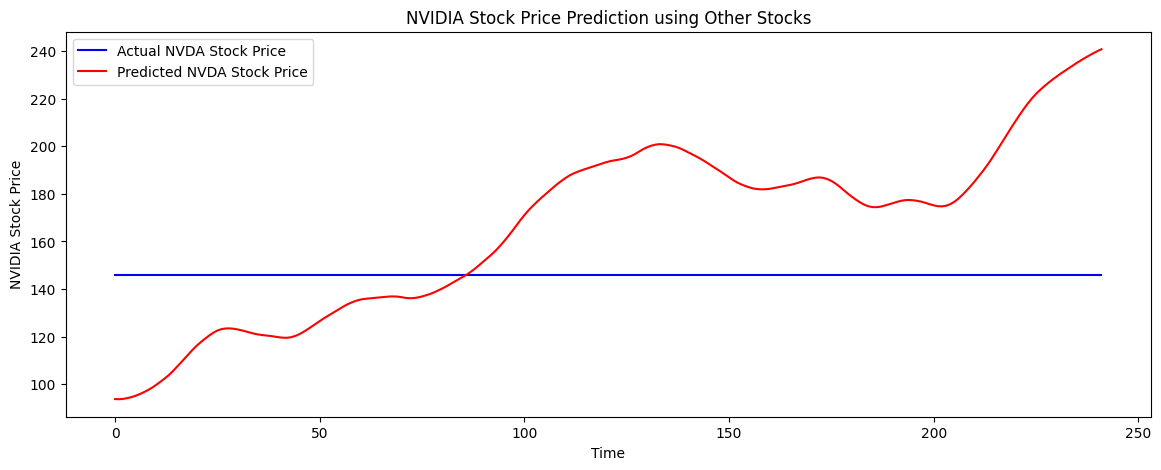

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Symbols of the feature stocks and the target stock
feature_symbols = ['AMZN', 'MSFT', 'AAPL', 'GM', 'TSLA', 'WMT']
target_symbol = 'NVDA'

# Download historical data for feature stocks
feature_data = {symbol: yf.download(symbol, start='2018-01-01', end='2024-01-01')['Adj Close'] for symbol in feature_symbols}
feature_df = pd.DataFrame(feature_data)

# Download historical data for the target stock
target_data = yf.download(target_symbol, start='2010-01-01', end='2023-01-01')['Adj Close']

# Align the data
all_data = feature_df.join(target_data)
all_data.fillna(method='ffill', inplace=True)

# Feature Scaling
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(all_data.iloc[:, :-1])
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(all_data.iloc[:, -1].values.reshape(-1, 1))

# Splitting data into training and validation sets
split = int(len(all_data) * 0.8)
X_train = scaled_features[:split]
y_train = scaled_target[:split]
X_validation = scaled_features[split:]
y_validation = scaled_target[split:]

# Creating sequences
def create_sequences(features, target, sequence_length=60):
    X, y = [], []
    for i in range(sequence_length, len(features)):
        X.append(features[i-sequence_length:i])
        y.append(target[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(X_train, y_train)
X_validation, y_validation = create_sequences(X_validation, y_validation)

# Model Building
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compiling and training the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_validation, y_validation), verbose=1)

# Predicting
predicted_stock_price = model.predict(X_validation)
predicted_stock_price = scaler_target.inverse_transform(predicted_stock_price)

# Visualization
plt.figure(figsize=(14,5))
real_price = scaler_target.inverse_transform(y_validation.reshape(-1, 1))
plt.plot(real_price, color='blue', label='Actual NVDA Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted NVDA Stock Price')
plt.title('NVIDIA Stock Price Prediction using Other Stocks')
plt.xlabel('Time')
plt.ylabel('NVIDIA Stock Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate the errors
mse = mean_squared_error(real_price, predicted_stock_price)
mae = mean_absolute_error(real_price, predicted_stock_price)
rmse = mean_squared_error(real_price, predicted_stock_price, squared=False)

# Print the errors
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")



Mean Absolute Error (MAE): 36.2946
Mean Squared Error (MSE): 1738.3874
Root Mean Squared Error (RMSE): 41.6940


In [ ]:
# all include

Epoch 1/5
30/30 [==============================] - 6s 76ms/step - loss: 0.0236
Epoch 2/5
30/30 [==============================] - 3s 81ms/step - loss: 0.0077
Epoch 3/5
30/30 [==============================] - 2s 54ms/step - loss: 0.0058
Epoch 4/5
30/30 [==============================] - 2s 54ms/step - loss: 0.0041
Epoch 5/5
8/8 [==============================] - 1s 17ms/step


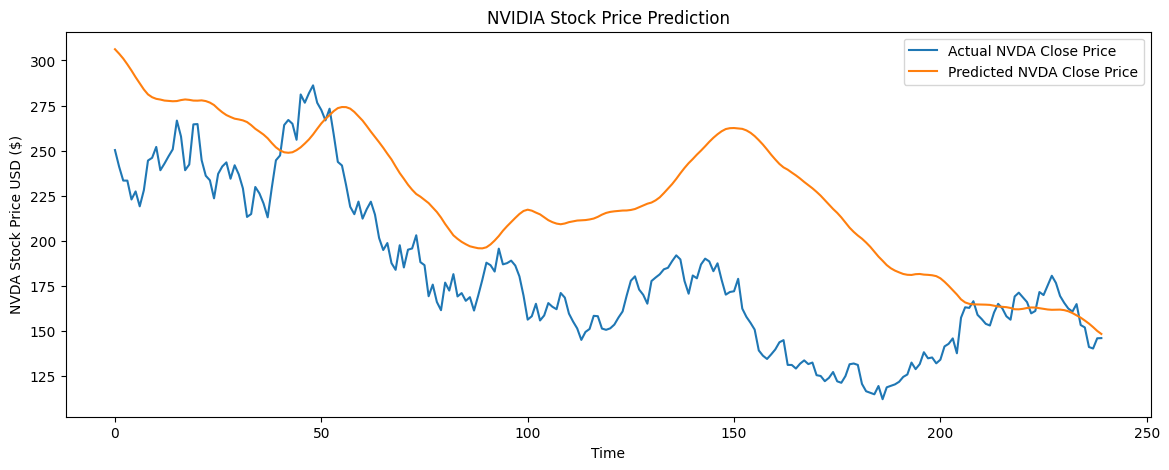

In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np

# Define the ticker symbols
symbols = ['AMZN', 'MSFT', 'AAPL', 'GM', 'TSLA', 'WMT', 'NVDA']

# Define the start and end dates
start_date = '2018-01-01'
end_date = '2023-01-01'

# Fetch stock data
def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data['Close']

stock_data = {}
for symbol in symbols:
    stock_data[symbol] = fetch_stock_data(symbol, start_date, end_date)

# Combine data into a DataFrame
combined_data = pd.concat(stock_data, axis=1)

# Separate NVDA data from the combined DataFrame and drop its column from combined_data
nvda_data = combined_data[['NVDA']].copy()
combined_data.drop(columns=['NVDA'], inplace=True)

# Assuming `combined_data` contains the historical closing prices of the stocks
# and `nvda_data` contains the historical closing prices of NVDA

# Scale the combined_data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_combined_data = scaler.fit_transform(combined_data)
scaler_nvda = MinMaxScaler(feature_range=(0, 1))
nvda_scaled = scaler_nvda.fit_transform(nvda_data)

# Prepare the data for LSTM model
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60
X, y = create_dataset(scaled_combined_data, nvda_scaled.flatten(), time_steps)

# Splitting dataset into train and test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM model architecture
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

# Predicting and inverse transforming the predictions
predictions = model.predict(X_test)
predictions = scaler_nvda.inverse_transform(predictions)

# Preparing the actual NVDA close price data for plotting
y_test_inv = scaler_nvda.inverse_transform(y_test.reshape(-1, 1))

# Plotting the stock price and predictions
plt.figure(figsize=(14,5))
plt.plot(y_test_inv, label='Actual NVDA Close Price')
plt.plot(predictions, label='Predicted NVDA Close Price')
plt.title('NVIDIA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price USD ($)')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test_inv, predictions))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 53.98465087787152


In [ ]:
# without GM

Epoch 1/5
30/30 [==============================] - 6s 55ms/step - loss: 0.0103
Epoch 2/5
30/30 [==============================] - 2s 54ms/step - loss: 0.0044
Epoch 3/5
30/30 [==============================] - 2s 53ms/step - loss: 0.0039
Epoch 4/5
30/30 [==============================] - 2s 54ms/step - loss: 0.0038
Epoch 5/5
8/8 [==============================] - 1s 22ms/step


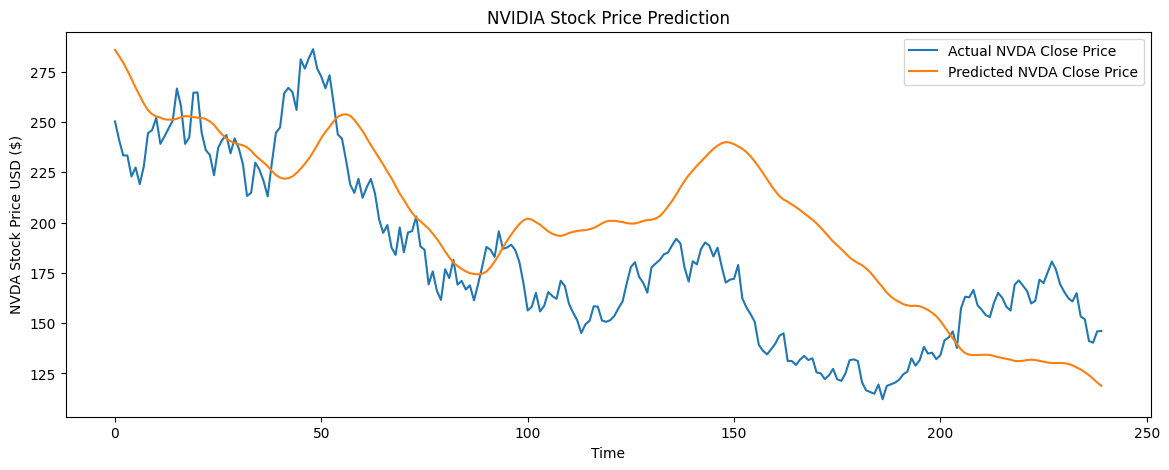

In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np

# Define the ticker symbols
symbols = ['AMZN', 'MSFT', 'AAPL', 'TSLA', 'WMT', 'NVDA']

# Define the start and end dates
start_date = '2018-01-01'
end_date = '2023-01-01'

# Fetch stock data
def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data['Close']

stock_data = {}
for symbol in symbols:
    stock_data[symbol] = fetch_stock_data(symbol, start_date, end_date)

# Combine data into a DataFrame
combined_data = pd.concat(stock_data, axis=1)

# Separate NVDA data from the combined DataFrame and drop its column from combined_data
nvda_data = combined_data[['NVDA']].copy()
combined_data.drop(columns=['NVDA'], inplace=True)

# Assuming `combined_data` contains the historical closing prices of the stocks
# and `nvda_data` contains the historical closing prices of NVDA

# Scale the combined_data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_combined_data = scaler.fit_transform(combined_data)
scaler_nvda = MinMaxScaler(feature_range=(0, 1))
nvda_scaled = scaler_nvda.fit_transform(nvda_data)

# Prepare the data for LSTM model
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60
X, y = create_dataset(scaled_combined_data, nvda_scaled.flatten(), time_steps)

# Splitting dataset into train and test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM model architecture
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

# Predicting and inverse transforming the predictions
predictions = model.predict(X_test)
predictions = scaler_nvda.inverse_transform(predictions)

# Preparing the actual NVDA close price data for plotting
y_test_inv = scaler_nvda.inverse_transform(y_test.reshape(-1, 1))

# Plotting the stock price and predictions
plt.figure(figsize=(14,5))
plt.plot(y_test_inv, label='Actual NVDA Close Price')
plt.plot(predictions, label='Predicted NVDA Close Price')
plt.title('NVIDIA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price USD ($)')
plt.legend()
plt.show()

In [ ]:

from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test_inv, predictions))
print(f'Root Mean Squared Error: {rmse}')



Root Mean Squared Error: 39.24280159235954


Epoch 1/5
30/30 [==============================] - 5s 54ms/step - loss: 0.0168
Epoch 2/5
30/30 [==============================] - 2s 54ms/step - loss: 0.0067
Epoch 3/5
30/30 [==============================] - 2s 54ms/step - loss: 0.0056
Epoch 4/5
30/30 [==============================] - 2s 77ms/step - loss: 0.0042
Epoch 5/5
8/8 [==============================] - 1s 16ms/step


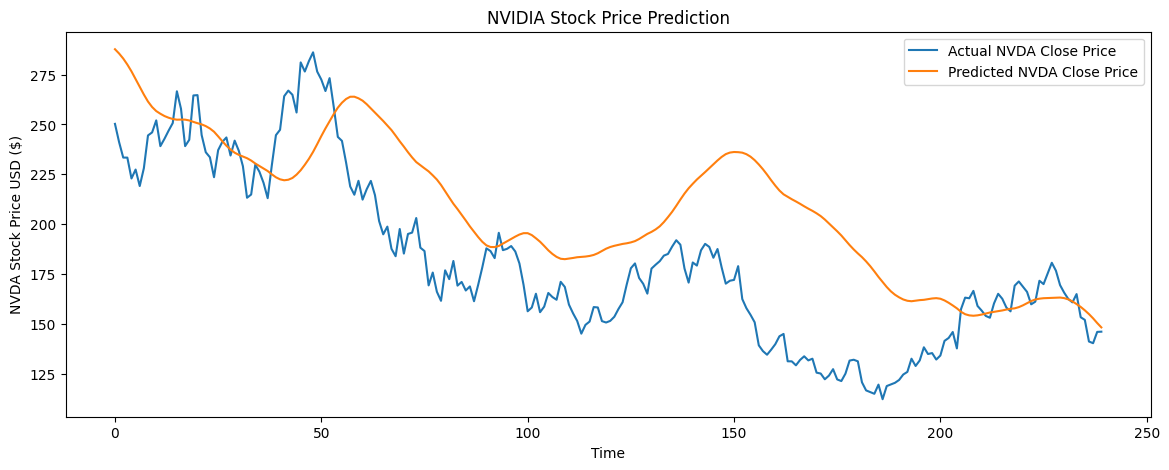

In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np

# Define the ticker symbols
symbols = ['AMZN', 'MSFT', 'AAPL', 'TSLA', 'NVDA']

# Define the start and end dates
start_date = '2018-01-01'
end_date = '2023-01-01'

# Fetch stock data
def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data['Close']

stock_data = {}
for symbol in symbols:
    stock_data[symbol] = fetch_stock_data(symbol, start_date, end_date)

# Combine data into a DataFrame
combined_data = pd.concat(stock_data, axis=1)

# Separate NVDA data from the combined DataFrame and drop its column from combined_data
nvda_data = combined_data[['NVDA']].copy()
combined_data.drop(columns=['NVDA'], inplace=True)

# Assuming `combined_data` contains the historical closing prices of the stocks
# and `nvda_data` contains the historical closing prices of NVDA

# Scale the combined_data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_combined_data = scaler.fit_transform(combined_data)
scaler_nvda = MinMaxScaler(feature_range=(0, 1))
nvda_scaled = scaler_nvda.fit_transform(nvda_data)

# Prepare the data for LSTM model
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60
X, y = create_dataset(scaled_combined_data, nvda_scaled.flatten(), time_steps)

# Splitting dataset into train and test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM model architecture
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

# Predicting and inverse transforming the predictions
predictions = model.predict(X_test)
predictions = scaler_nvda.inverse_transform(predictions)

# Preparing the actual NVDA close price data for plotting
y_test_inv = scaler_nvda.inverse_transform(y_test.reshape(-1, 1))

# Plotting the stock price and predictions
plt.figure(figsize=(14,5))
plt.plot(y_test_inv, label='Actual NVDA Close Price')
plt.plot(predictions, label='Predicted NVDA Close Price')
plt.title('NVIDIA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price USD ($)')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test_inv, predictions))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 39.999320910755884


# Try Model Concatenating

## GRU LSTM CNN

## Find Optimal Hyperparameters

Epoch 1/100
24/24 [==============================] - 7s 72ms/step - loss: 0.0520 - val_loss: 0.0441 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 1s 36ms/step - loss: 0.0017 - val_loss: 0.0558 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 1s 34ms/step - loss: 0.0010 - val_loss: 0.0725 - lr: 0.0010
Epoch 4/100
24/24 [==============================] - 1s 33ms/step - loss: 7.3113e-04 - val_loss: 0.0759 - lr: 0.0010
Epoch 5/100
24/24 [==============================] - 1s 32ms/step - loss: 5.7672e-04 - val_loss: 0.0777 - lr: 0.0010
Epoch 6/100
24/24 [==============================] - 1s 33ms/step - loss: 5.1921e-04 - val_loss: 0.0751 - lr: 0.0010
Epoch 7/100
24/24 [==============================] - 1s 33ms/step - loss: 4.8451e-04 - val_loss: 0.0694 - lr: 0.0010
Epoch 8/100
24/24 [==============================] - 1s 33ms/step - loss: 4.1649e-04 - val_loss: 0.0797 - lr: 0.0010
Epoch 9/100
24/24 [==============================] - 1s 34ms/step - loss: 3.

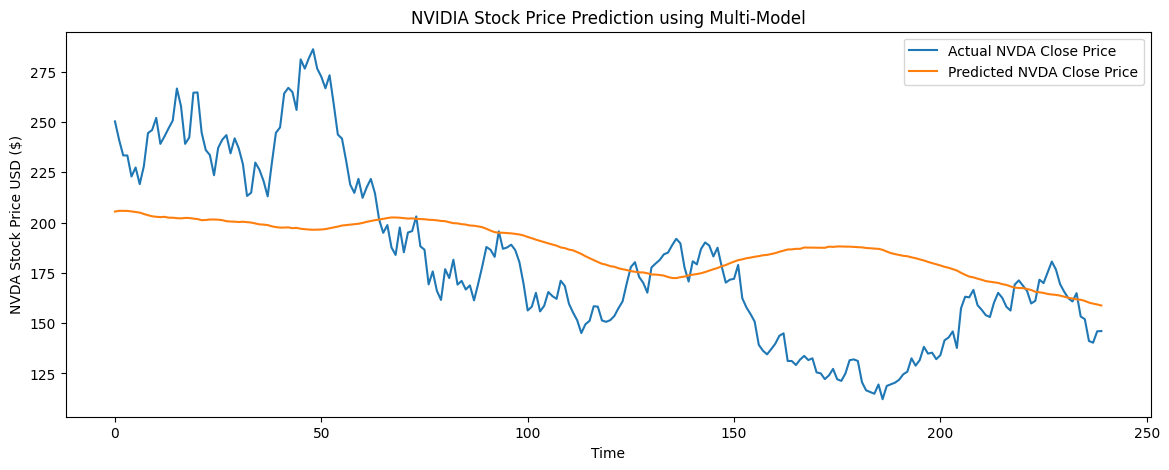

Root Mean Squared Error: 37.52522609638047


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Concatenate, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data['Close']

symbols = ['AMZN', 'MSFT', 'AAPL', 'GM', 'TSLA', 'WMT', 'NVDA']
stock_data = {symbol: fetch_stock_data(symbol, '2018-01-01', '2023-01-01') for symbol in symbols}
combined_data = pd.concat(stock_data, axis=1)
nvda_data = combined_data[['NVDA']].copy()
combined_data.drop(columns=['NVDA'], inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_combined_data = scaler.fit_transform(combined_data)
scaler_nvda = MinMaxScaler(feature_range=(0, 1))
nvda_scaled = scaler_nvda.fit_transform(nvda_data)

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60
X, y = create_dataset(scaled_combined_data, nvda_scaled.flatten(), time_steps)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# LSTM branch
lstm_out = LSTM(50, return_sequences=True)(input_layer)
lstm_out = Flatten()(lstm_out)

# GRU branch
gru_out = GRU(50, return_sequences=True)(input_layer)
gru_out = Flatten()(gru_out)

# CNN branch
cnn_out = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
cnn_out = MaxPooling1D(pool_size=2)(cnn_out)
cnn_out = Flatten()(cnn_out)

concat = Concatenate()([lstm_out, gru_out, cnn_out])
concat = Dropout(0.3)(concat)  # Added Dropout for regularization

dense_out = Dense(50, activation='relu')(concat)
output_layer = Dense(1, activation='linear')(dense_out)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping, reduce_lr])

predictions = model.predict(X_test)
predictions = scaler_nvda.inverse_transform(predictions)

y_test_inv = scaler_nvda.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(14,5))
plt.plot(y_test_inv, label='Actual NVDA Close Price')
plt.plot(predictions, label='Predicted NVDA Close Price')
plt.title('NVIDIA Stock Price Prediction using Multi-Model')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price USD ($)')
plt.legend()
plt.show()

rmse = sqrt(mean_squared_error(y_test_inv, predictions))
print(f'Root Mean Squared Error: {rmse}')


## Old Version

Epoch 1/5
24/24 [==============================] - 7s 116ms/step - loss: 0.0755 - val_loss: 0.1265
Epoch 2/5
24/24 [==============================] - 2s 79ms/step - loss: 0.0012 - val_loss: 0.0897
Epoch 3/5
24/24 [==============================] - 1s 57ms/step - loss: 4.1654e-04 - val_loss: 0.0747
Epoch 4/5
24/24 [==============================] - 1s 55ms/step - loss: 4.1420e-04 - val_loss: 0.0862
Epoch 5/5
8/8 [==============================] - 1s 14ms/step


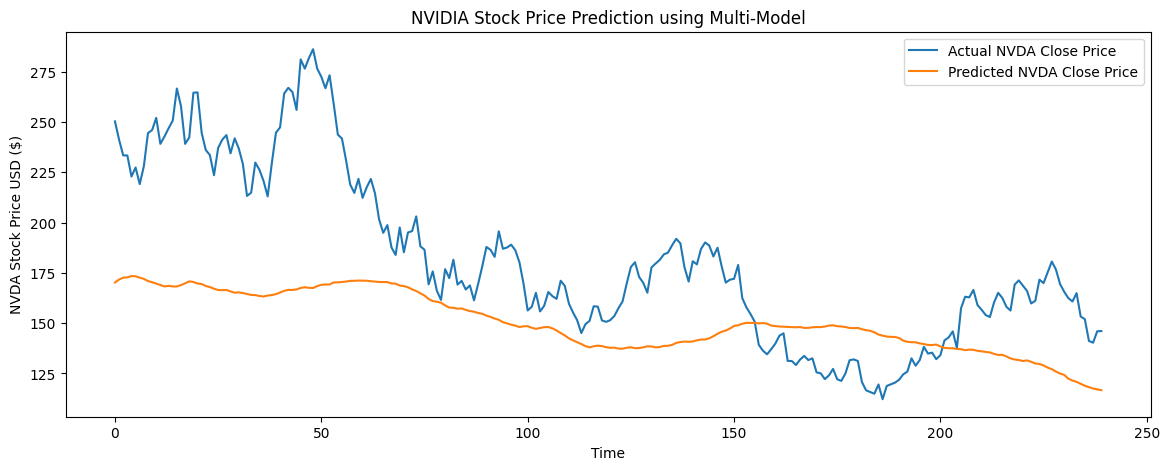

Root Mean Squared Error: 45.86529948305178


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Concatenate, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Fetch and prepare the data (as you have already done)
symbols = ['AMZN', 'MSFT', 'AAPL', 'GM', 'TSLA', 'WMT', 'NVDA']
start_date = '2018-01-01'
end_date = '2023-01-01'

def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data['Close']

stock_data = {}
for symbol in symbols:
    stock_data[symbol] = fetch_stock_data(symbol, start_date, end_date)

combined_data = pd.concat(stock_data, axis=1)
nvda_data = combined_data[['NVDA']].copy()
combined_data.drop(columns=['NVDA'], inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_combined_data = scaler.fit_transform(combined_data)
scaler_nvda = MinMaxScaler(feature_range=(0, 1))
nvda_scaled = scaler_nvda.fit_transform(nvda_data)

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60
X, y = create_dataset(scaled_combined_data, nvda_scaled.flatten(), time_steps)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Multi-model architecture
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# LSTM branch
lstm_out = LSTM(50, return_sequences=True)(input_layer)
lstm_out = Flatten()(lstm_out)

# GRU branch
gru_out = GRU(50, return_sequences=True)(input_layer)
gru_out = Flatten()(gru_out)

# CNN branch
cnn_out = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
cnn_out = MaxPooling1D(pool_size=2)(cnn_out)
cnn_out = Flatten()(cnn_out)

# Concatenate all branches
concat = Concatenate()([lstm_out, gru_out, cnn_out])

# Final Dense layers
dense_out = Dense(50, activation='relu')(concat)
output_layer = Dense(1, activation='linear')(dense_out)

# Create and compile the multi-model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the multi-model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Predicting and inverse transforming the predictions
predictions = model.predict(X_test)
predictions = scaler_nvda.inverse_transform(predictions)

# Preparing the actual NVDA close price data for plotting
y_test_inv = scaler_nvda.inverse_transform(y_test.reshape(-1, 1))

# Plotting the stock price and predictions
plt.figure(figsize=(14,5))
plt.plot(y_test_inv, label='Actual NVDA Close Price')
plt.plot(predictions, label='Predicted NVDA Close Price')
plt.title('NVIDIA Stock Price Prediction using Multi-Model')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price USD ($)')
plt.legend()
plt.show()

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test_inv, predictions))
print(f'Root Mean Squared Error: {rmse}')


## Bidirectional LSTM (BiLSTM), GRU, and a simple Dense network

## Adding a few more layers

Epoch 1/100
24/24 [==============================] - 14s 164ms/step - loss: 0.0572 - val_loss: 0.1611 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 2s 80ms/step - loss: 0.0031 - val_loss: 0.0542 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 2s 80ms/step - loss: 0.0014 - val_loss: 0.0757 - lr: 0.0010
Epoch 4/100
24/24 [==============================] - 2s 82ms/step - loss: 0.0010 - val_loss: 0.0824 - lr: 0.0010
Epoch 5/100
24/24 [==============================] - 2s 86ms/step - loss: 0.0010 - val_loss: 0.0811 - lr: 0.0010
Epoch 6/100
24/24 [==============================] - 2s 80ms/step - loss: 0.0011 - val_loss: 0.0595 - lr: 0.0010
Epoch 7/100
24/24 [==============================] - 2s 85ms/step - loss: 8.4749e-04 - val_loss: 0.0792 - lr: 0.0010
Epoch 8/100
24/24 [==============================] - 2s 83ms/step - loss: 6.7644e-04 - val_loss: 0.0645 - lr: 0.0010
Epoch 9/100
24/24 [==============================] - 2s 81ms/step - loss: 8.6993e-04 -

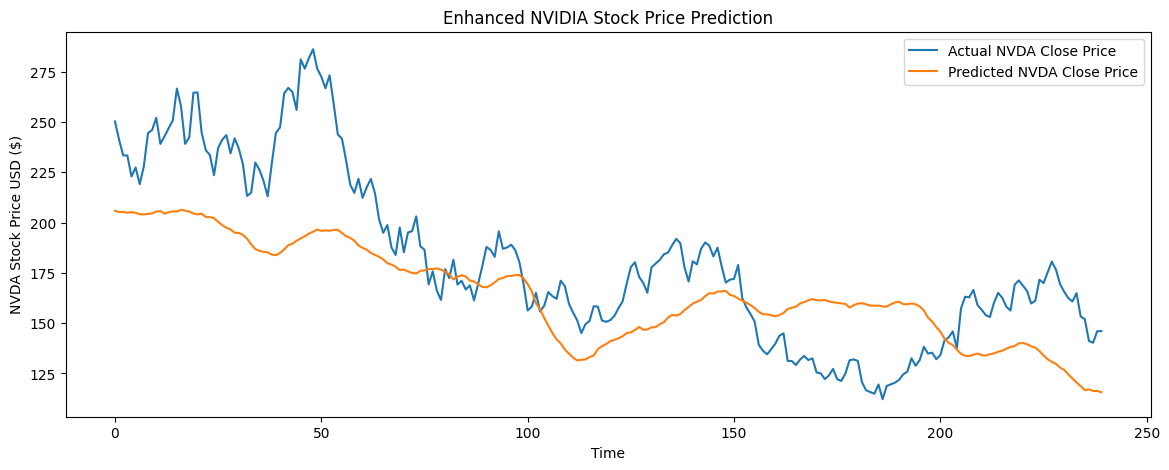

Root Mean Squared Error: 33.49966430726417


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, GRU, Dense, Concatenate, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Fetch and prepare data
def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data['Close']

symbols = ['AMZN', 'MSFT', 'AAPL', 'GM', 'TSLA', 'WMT', 'NVDA']
stock_data = {symbol: fetch_stock_data(symbol, '2018-01-01', '2023-01-01') for symbol in symbols}
combined_data = pd.concat(stock_data, axis=1)
nvda_data = combined_data[['NVDA']].copy()
combined_data.drop(columns=['NVDA'], inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_combined_data = scaler.fit_transform(combined_data)
scaler_nvda = MinMaxScaler(feature_range=(0, 1))
nvda_scaled = scaler_nvda.fit_transform(nvda_data)

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60
X, y = create_dataset(scaled_combined_data, nvda_scaled.flatten(), time_steps)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Increasing complexity with more units and additional layers
bilstm_out = Bidirectional(LSTM(100, return_sequences=True))(input_layer)
bilstm_out = LSTM(50, return_sequences=False)(bilstm_out)
bilstm_out = Flatten()(bilstm_out)

gru_out = GRU(100, return_sequences=True)(input_layer)
gru_out = GRU(50, return_sequences=False)(gru_out)
gru_out = Flatten()(gru_out)

dense_out = Dense(100, activation='relu')(input_layer)
dense_out = Flatten()(dense_out)

concat = Concatenate()([bilstm_out, gru_out, dense_out])
concat = Dropout(0.3)(concat)  # Added Dropout

final_dense_out = Dense(100, activation='relu')(concat)
output_layer = Dense(1, activation='linear')(final_dense_out)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping, reduce_lr])

predictions = model.predict(X_test)
predictions = scaler_nvda.inverse_transform(predictions)

y_test_inv = scaler_nvda.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(14,5))
plt.plot(y_test_inv, label='Actual NVDA Close Price')
plt.plot(predictions, label='Predicted NVDA Close Price')
plt.title('Enhanced NVIDIA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price USD ($)')
plt.legend()
plt.show()

rmse = sqrt(mean_squared_error(y_test_inv, predictions))
print(f'Root Mean Squared Error: {rmse}')


## Old Version

Epoch 1/5
24/24 [==============================] - 10s 177ms/step - loss: 0.4993 - val_loss: 0.0598
Epoch 2/5
24/24 [==============================] - 2s 79ms/step - loss: 0.0125 - val_loss: 0.1331
Epoch 3/5
24/24 [==============================] - 2s 81ms/step - loss: 0.0027 - val_loss: 0.0645
Epoch 4/5
24/24 [==============================] - 2s 82ms/step - loss: 0.0015 - val_loss: 0.0753
Epoch 5/5
8/8 [==============================] - 2s 37ms/step


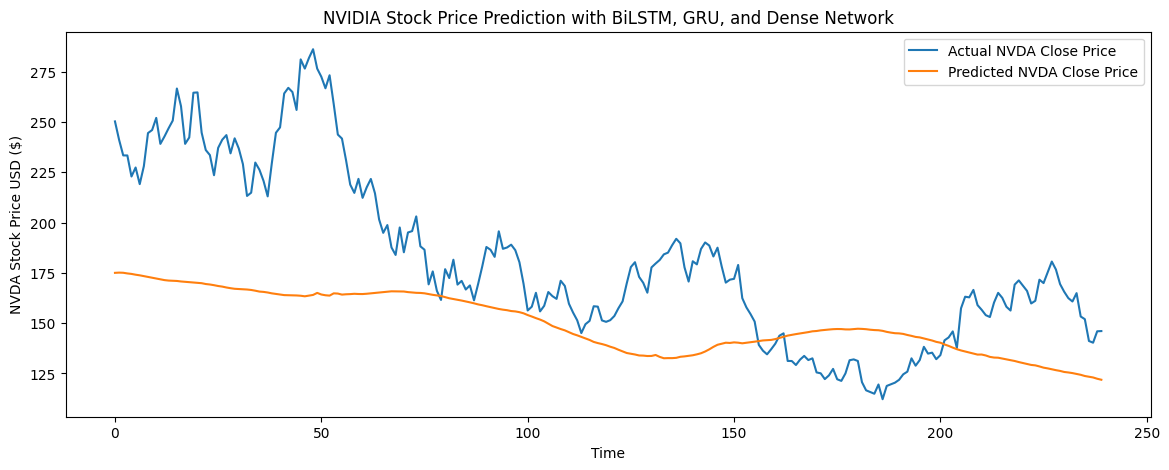

Root Mean Squared Error: 46.59306369123624


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, GRU, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

# Fetch and prepare the data (reuse your existing data fetching and preprocessing)
symbols = ['AMZN', 'MSFT', 'AAPL', 'GM', 'TSLA', 'WMT', 'NVDA']
start_date = '2018-01-01'
end_date = '2023-01-01'

def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data['Close']

stock_data = {}
for symbol in symbols:
    stock_data[symbol] = fetch_stock_data(symbol, start_date, end_date)

combined_data = pd.concat(stock_data, axis=1)
nvda_data = combined_data[['NVDA']].copy()
combined_data.drop(columns=['NVDA'], inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_combined_data = scaler.fit_transform(combined_data)
scaler_nvda = MinMaxScaler(feature_range=(0, 1))
nvda_scaled = scaler_nvda.fit_transform(nvda_data)

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60
X, y = create_dataset(scaled_combined_data, nvda_scaled.flatten(), time_steps)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Multi-model architecture
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Bidirectional LSTM branch
bilstm_out = Bidirectional(LSTM(50, return_sequences=True))(input_layer)
bilstm_out = Flatten()(bilstm_out)

# GRU branch
gru_out = GRU(50, return_sequences=True)(input_layer)
gru_out = Flatten()(gru_out)

# Dense branch
dense_out = Dense(50, activation='relu')(input_layer)
dense_out = Flatten()(dense_out)

# Concatenate all branches
concat = Concatenate()([bilstm_out, gru_out, dense_out])

# Final Dense layer for output
final_dense_out = Dense(50, activation='relu')(concat)
output_layer = Dense(1, activation='linear')(final_dense_out)

# Create and compile the multi-model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the multi-model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Predicting and inverse transforming the predictions
predictions = model.predict(X_test)
predictions = scaler_nvda.inverse_transform(predictions)

# Preparing the actual NVDA close price data for plotting
y_test_inv = scaler_nvda.inverse_transform(y_test.reshape(-1, 1))

# Plotting the stock price and predictions
plt.figure(figsize=(14,5))
plt.plot(y_test_inv, label='Actual NVDA Close Price')
plt.plot(predictions, label='Predicted NVDA Close Price')
plt.title('NVIDIA Stock Price Prediction with BiLSTM, GRU, and Dense Network')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price USD ($)')
plt.legend()
plt.show()

rmse = sqrt(mean_squared_error(y_test_inv, predictions))
print(f'Root Mean Squared Error: {rmse}')


## GRU LSTM Attention Layers

## Adding a few more layers

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 60, 6)]              0         []                            
                                                                                                  
 lstm_12 (LSTM)              (None, 60, 100)              42800     ['input_5[0][0]']             
                                                                                                  
 lstm_13 (LSTM)              (None, 60, 50)               30200     ['lstm_12[0][0]']             
                                                                                                  
 gru_6 (GRU)                 (None, 60, 100)              45600     ['lstm_13[0][0]']             
                                                                                            

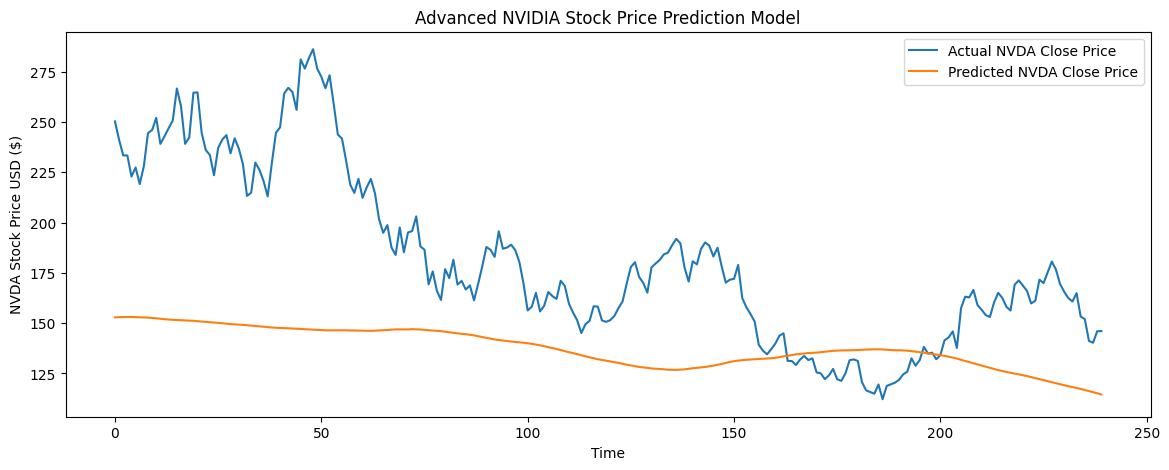

Root Mean Squared Error: 57.31670565826679


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Concatenate, Dropout, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

# Fetching stock data
def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data['Close']

symbols = ['AMZN', 'MSFT', 'AAPL', 'GM', 'TSLA', 'WMT', 'NVDA']
stock_data = {symbol: fetch_stock_data(symbol, '2018-01-01', '2023-01-01') for symbol in symbols}
combined_data = pd.concat(stock_data, axis=1)
nvda_data = combined_data[['NVDA']].copy()
combined_data.drop(columns=['NVDA'], inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_combined_data = scaler.fit_transform(combined_data)
scaler_nvda = MinMaxScaler(feature_range=(0, 1))
nvda_scaled = scaler_nvda.fit_transform(nvda_data)

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60
X, y = create_dataset(scaled_combined_data, nvda_scaled.flatten(), time_steps)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Stacked LSTM and GRU layers with increased units
lstm_out = LSTM(100, return_sequences=True)(input_layer)
lstm_out = LSTM(50, return_sequences=True)(lstm_out)
gru_out = GRU(100, return_sequences=True)(lstm_out)
gru_out = GRU(50, return_sequences=True)(gru_out)

# Advanced Attention Mechanism
attention_out = MultiHeadAttention(num_heads=2, key_dim=50)(gru_out, gru_out)

# Concatenation of all outputs
concat = Concatenate()([lstm_out, gru_out, attention_out])

# Global Average Pooling to reduce sequence dimension
global_pool = GlobalAveragePooling1D()(concat)

# Dense layers with increased complexity
dense_out = Dense(100, activation='relu')(global_pool)
dense_out = Dropout(0.3)(dense_out)  # Dropout added for regularization
output_layer = Dense(1, activation='linear')(dense_out)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary to check the architecture
model.summary()

# Train the model with callbacks for early stopping and learning rate adjustment
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict and scale back the predictions
predictions = model.predict(X_test)
predictions = scaler_nvda.inverse_transform(predictions.reshape(-1, 1))

# Actual data scaling back
y_test_inv = scaler_nvda.inverse_transform(y_test.reshape(-1, 1))

# Plot results
plt.figure(figsize=(14,5))
plt.plot(y_test_inv, label='Actual NVDA Close Price')
plt.plot(predictions, label='Predicted NVDA Close Price')
plt.title('Advanced NVIDIA Stock Price Prediction Model')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price USD ($)')
plt.legend()
plt.show()

# Calculate and print RMSE
rmse = sqrt(mean_squared_error(y_test_inv, predictions))
print(f'Root Mean Squared Error: {rmse}')


## Old Version

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 60, 6)]              0         []                            
                                                                                                  
 lstm_14 (LSTM)              (None, 60, 50)               11400     ['input_6[0][0]']             
                                                                                                  
 gru_5 (GRU)                 (None, 60, 50)               15300     ['lstm_14[0][0]']             
                                                                                                  
 attention_2 (Attention)     (None, 60, 50)               0         ['gru_5[0][0]',               
                                                                     'gru_5[0][0]']         

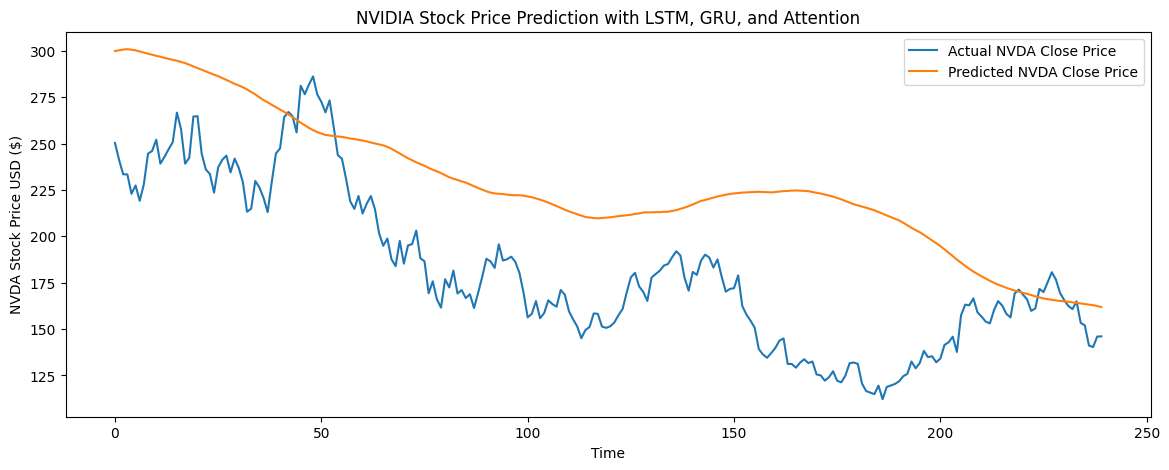

Root Mean Squared Error: 54.84072917825341


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Concatenate, Dropout, Attention
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

# Fetch and prepare the data (reuse your existing data fetching and preprocessing)
symbols = ['AMZN', 'MSFT', 'AAPL', 'GM', 'TSLA', 'WMT', 'NVDA']
start_date = '2018-01-01'
end_date = '2023-01-01'

def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data['Close']

stock_data = {}
for symbol in symbols:
    stock_data[symbol] = fetch_stock_data(symbol, start_date, end_date)

combined_data = pd.concat(stock_data, axis=1)
nvda_data = combined_data[['NVDA']].copy()
combined_data.drop(columns=['NVDA'], inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_combined_data = scaler.fit_transform(combined_data)
scaler_nvda = MinMaxScaler(feature_range=(0, 1))
nvda_scaled = scaler_nvda.fit_transform(nvda_data)

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60
X, y = create_dataset(scaled_combined_data, nvda_scaled.flatten(), time_steps)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# Model architecture
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# LSTM layer
lstm_out = LSTM(50, return_sequences=True)(input_layer)

# GRU layer
gru_out = GRU(50, return_sequences=True)(lstm_out)

# Attention layer
attention_out = Attention()([gru_out, gru_out])

# Concatenation
concat = Concatenate()([lstm_out, gru_out, attention_out])

# Adding a global average pooling layer to reduce the sequence dimension
global_pool = tf.keras.layers.GlobalAveragePooling1D()(concat)

# Dense layer
dense_out = Dense(50, activation='relu')(global_pool)
output_layer = Dense(1, activation='linear')(dense_out)

# Create and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

# Predict and inverse transform the predictions
predictions = model.predict(X_test)
predictions = scaler_nvda.inverse_transform(predictions.reshape(-1, 1))

# Preparing the actual NVDA close price data for plotting
y_test_inv = scaler_nvda.inverse_transform(y_test.reshape(-1, 1))

# Plotting the stock price and predictions
plt.figure(figsize=(14,5))
plt.plot(y_test_inv, label='Actual NVDA Close Price')
plt.plot(predictions, label='Predicted NVDA Close Price')
plt.title('NVIDIA Stock Price Prediction with LSTM, GRU, and Attention')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price USD ($)')
plt.legend()
plt.show()

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test_inv, predictions))
print(f'Root Mean Squared Error: {rmse}')



## Dense network, Conv1D (for extracting local temporal features), and LSTM (for capturing long-term dependencies)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 60, 6)]           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 58, 64)            1216      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 29, 64)            0         
 g1D)                                                            
                                                                 
 lstm_15 (LSTM)              (None, 50)                23000     
                                                                 
 dense_13 (Dense)            (None, 50)                2550      
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                           

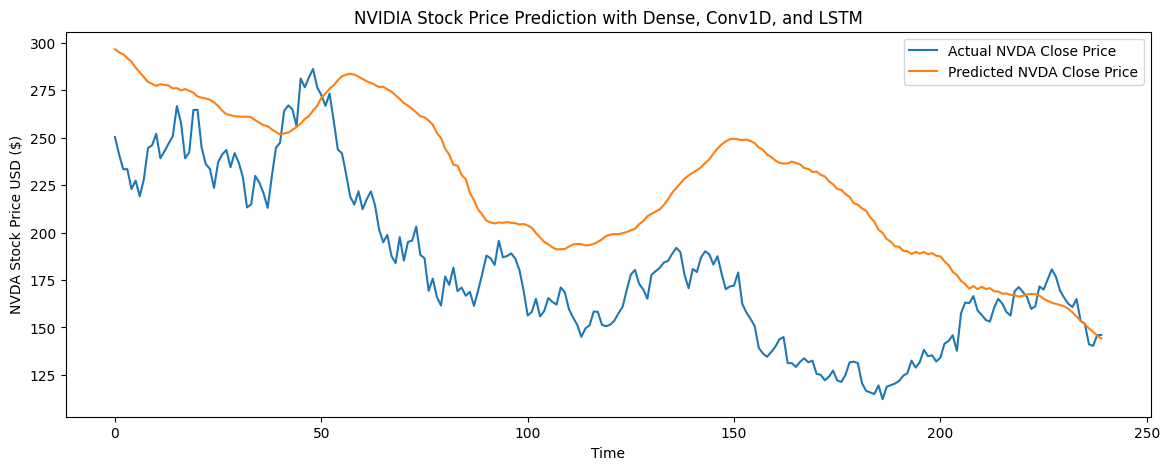

Root Mean Squared Error: 55.26480947035524


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

# Fetch and prepare the data
symbols = ['AMZN', 'MSFT', 'AAPL', 'GM', 'TSLA', 'WMT', 'NVDA']
start_date = '2018-01-01'
end_date = '2023-01-01'

def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data['Close']

stock_data = {}
for symbol in symbols:
    stock_data[symbol] = fetch_stock_data(symbol, start_date, end_date)

combined_data = pd.concat(stock_data, axis=1)
nvda_data = combined_data[['NVDA']].copy()
combined_data.drop(columns=['NVDA'], inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_combined_data = scaler.fit_transform(combined_data)
scaler_nvda = MinMaxScaler(feature_range=(0, 1))
nvda_scaled = scaler_nvda.fit_transform(nvda_data)

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60
X, y = create_dataset(scaled_combined_data, nvda_scaled.flatten(), time_steps)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Model architecture
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Conv1D layer
conv1_out = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
conv1_out = MaxPooling1D(pool_size=2)(conv1_out)

# LSTM layer
lstm_out = LSTM(50, return_sequences=False)(conv1_out)

# Dense layer
dense_out = Dense(50, activation='relu')(lstm_out)
output_layer = Dense(1, activation='linear')(dense_out)

# Create and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

# Predict and inverse transform the predictions
predictions = model.predict(X_test)
predictions = scaler_nvda.inverse_transform(predictions.reshape(-1, 1))

# Preparing the actual NVDA close price data for plotting
y_test_inv = scaler_nvda.inverse_transform(y_test.reshape(-1, 1))

# Plotting the stock price and predictions
plt.figure(figsize=(14,5))
plt.plot(y_test_inv, label='Actual NVDA Close Price')
plt.plot(predictions, label='Predicted NVDA Close Price')
plt.title('NVIDIA Stock Price Prediction with Dense, Conv1D, and LSTM')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price USD ($)')
plt.legend()
plt.show()

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test_inv, predictions))
print(f'Root Mean Squared Error: {rmse}')


# Transformer layer with LSTM

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 60, 6)]              0         []                            
                                                                                                  
 multi_head_attention_1 (Mu  (None, 60, 6)                6918      ['input_6[0][0]',             
 ltiHeadAttention)                                                   'input_6[0][0]']             
                                                                                                  
 dropout_16 (Dropout)        (None, 60, 6)                0         ['multi_head_attention_1[0][0]
                                                                    ']                            
                                                                                            

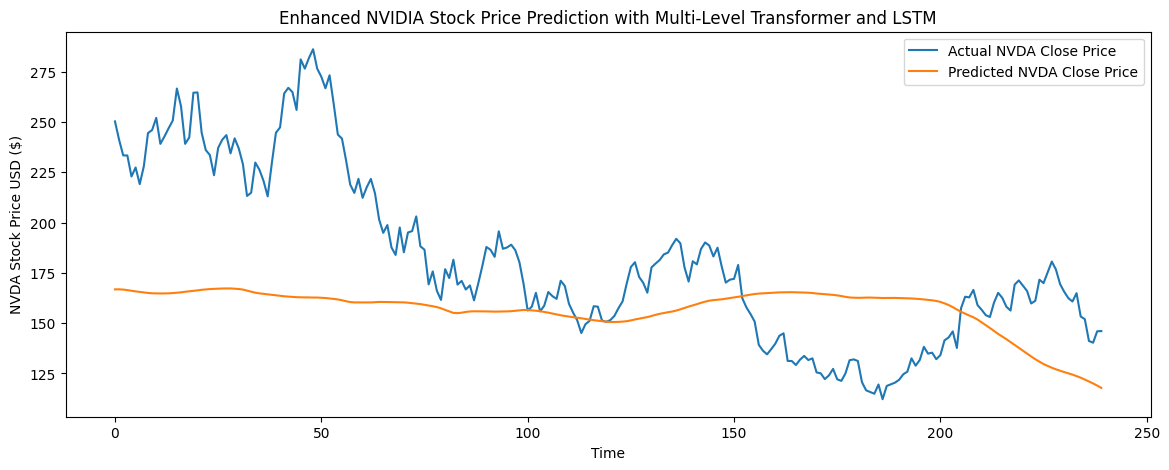

Root Mean Squared Error: 47.75423378382045


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, MultiHeadAttention, LayerNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

# Fetching and preparing the data
def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data['Close']

symbols = ['AMZN', 'MSFT', 'AAPL', 'GM', 'TSLA', 'WMT', 'NVDA']
stock_data = {symbol: fetch_stock_data(symbol, '2018-01-01', '2023-01-01') for symbol in symbols}
combined_data = pd.concat(stock_data, axis=1)
nvda_data = combined_data[['NVDA']].copy()
combined_data.drop(columns=['NVDA'], inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_combined_data = scaler.fit_transform(combined_data)
scaler_nvda = MinMaxScaler(feature_range=(0, 1))
nvda_scaled = scaler_nvda.fit_transform(nvda_data)

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60
X, y = create_dataset(scaled_combined_data, nvda_scaled.flatten(), time_steps)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# First Transformer block
attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(input_layer, input_layer)
attention_output = Dropout(0.2)(attention_output)
transformed_input = LayerNormalization(epsilon=1e-6)(attention_output + input_layer)

# Second Transformer block
attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(transformed_input, transformed_input)
attention_output = Dropout(0.2)(attention_output)
transformed_input = LayerNormalization(epsilon=1e-6)(attention_output + transformed_input)

# LSTM layers
lstm_out = LSTM(100, return_sequences=True)(transformed_input)
lstm_out = LSTM(50, return_sequences=False)(lstm_out)

# Dense layers
dense_out = Dense(100, activation='relu')(lstm_out)
output_layer = Dense(1, activation='linear')(dense_out)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping, reduce_lr])

predictions = model.predict(X_test)
predictions = scaler_nvda.inverse_transform(predictions.reshape(-1, 1))

y_test_inv = scaler_nvda.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(14,5))
plt.plot(y_test_inv, label='Actual NVDA Close Price')
plt.plot(predictions, label='Predicted NVDA Close Price')
plt.title('Enhanced NVIDIA Stock Price Prediction with Multi-Level Transformer and LSTM')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price USD ($)')
plt.legend()
plt.show()

rmse = sqrt(mean_squared_error(y_test_inv, predictions))
print(f'Root Mean Squared Error: {rmse}')


## Old Version of model

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 60, 6)]              0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 60, 6)                6918      ['input_8[0][0]',             
 iHeadAttention)                                                     'input_8[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 60, 6)                0         ['multi_head_attention[0][0]']
                                                                                                  
 tf.__operators__.add (TFOp  (None, 60, 6)                0         ['dropout_9[0][0]',     

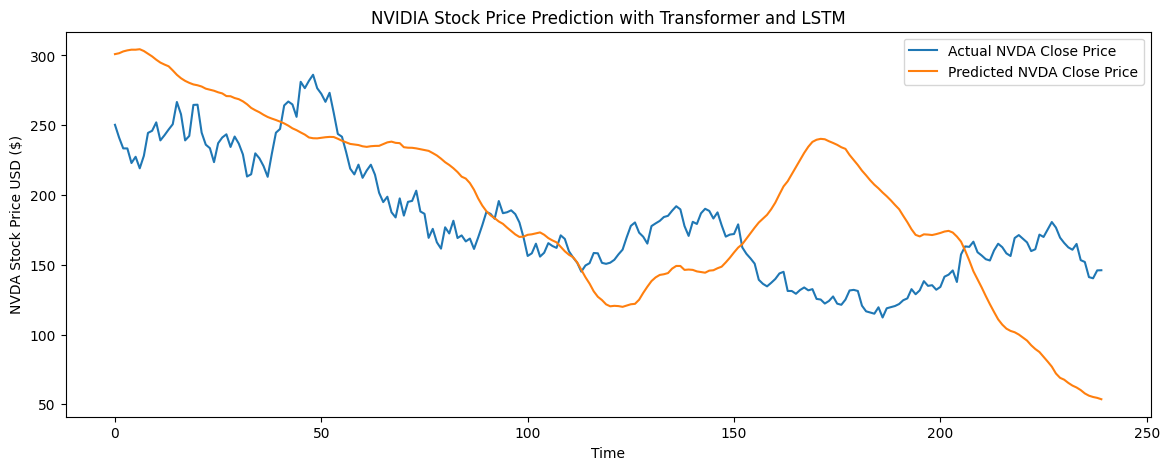

Root Mean Squared Error: 54.17824741249584


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

# Fetch and prepare the data
symbols = ['AMZN', 'MSFT', 'AAPL', 'GM', 'TSLA', 'WMT', 'NVDA']
start_date = '2018-01-01'
end_date = '2023-01-01'

def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data['Close']

stock_data = {}
for symbol in symbols:
    stock_data[symbol] = fetch_stock_data(symbol, start_date, end_date)

combined_data = pd.concat(stock_data, axis=1)
nvda_data = combined_data[['NVDA']].copy()
combined_data.drop(columns=['NVDA'], inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_combined_data = scaler.fit_transform(combined_data)
scaler_nvda = MinMaxScaler(feature_range=(0, 1))
nvda_scaled = scaler_nvda.fit_transform(nvda_data)

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60
X, y = create_dataset(scaled_combined_data, nvda_scaled.flatten(), time_steps)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Model architecture
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Transformer block
attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(input_layer, input_layer)
attention_output = Dropout(0.1)(attention_output)
attention_output = LayerNormalization(epsilon=1e-6)(attention_output + input_layer)

# LSTM layer
lstm_out = LSTM(50)(attention_output)

# Dense layer
dense_out = Dense(50, activation='relu')(lstm_out)
output_layer = Dense(1, activation='linear')(dense_out)

# Create and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

# Predict and inverse transform the predictions
predictions = model.predict(X_test)
predictions = scaler_nvda.inverse_transform(predictions.reshape(-1, 1))

# Preparing the actual NVDA close price data for plotting
y_test_inv = scaler_nvda.inverse_transform(y_test.reshape(-1, 1))

# Plotting the stock price and predictions
plt.figure(figsize=(14,5))
plt.plot(y_test_inv, label='Actual NVDA Close Price')
plt.plot(predictions, label='Predicted NVDA Close Price')
plt.title('NVIDIA Stock Price Prediction with Transformer and LSTM')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price USD ($)')
plt.legend()
plt.show()

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test_inv, predictions))
print(f'Root Mean Squared Error: {rmse}')
